In [1]:
### running analysis for John
### basically there is no result

import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import spatial

import import_ipynb
import func_format
import func_analysis

importing Jupyter notebook from func_format.ipynb
importing Jupyter notebook from func_analysis.ipynb


In [2]:
def calculate_zscore(neuron, start, stop, basestart, basestop, binsize):
    spikes = func_analysis.extractSpikes(neuron, start, stop)
    fr = func_analysis.firingrate(spikes, binsize, start, stop, smooth=False)
    bins = np.arange(start, stop, binsize)
    
    baselinespikes = func_analysis.extractSpikes(neuron, basestart, basestop)
    baselinefr = func_analysis.firingrate(baselinespikes, binsize, basestart, basestop, smooth=True, smoothkernel = 1)
    meanbaseline = np.mean(baselinefr)
    stdbaseline = np.std(baselinefr)
    
    zscore_fr = (fr-meanbaseline)/stdbaseline
    zscorebaseline = (baselinefr-meanbaseline)/stdbaseline
    return(zscore_fr, bins)

In [3]:
ratID = ['Amygdala6', 'Amygdala8', 'Amygdala10', 'Amygdala11']
dates = ['13042019', '01102019', '27062020', '06072020']

savedir = 'F:/FiringStartAnalysis/'
func_format.foldercheck(savedir)
intvalues = np.loadtxt('F:/InteractionPresentation_synctimes.csv', delimiter = ',', dtype = str)
neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)
distanceheadall =np.zeros(10)
velocityall = np.zeros(10)
distancetailall = np.zeros(10)
headdtoheadall = np.zeros(10)
headdtotailall = np.zeros(10)
timeofmaxfiringall = np.zeros(10)
timeafterstartall = np.zeros(10)
timebeforecontactall = np.zeros(10)
fraction_timeafterstartall = np.zeros(10)

distancerat = []
velocityrat = []
distancetailrat = []
headdtoheadrat = []
headdtotailrat = []

normzscorefiring = []

for r, rat in enumerate(ratID):
    date = dates[r]
    
    configpath = 'F:/'+rat+'/Parameters_'+date+'.yml'
    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    neuronpath = 'F:/'+rat+'/Electrophys/'+date+'/SpikeTimes/Neurons_BLA/'
    
    neuronprofile2 = neuronprofile[neuronprofile[:,0] == rat]
    intvalues2 = intvalues[intvalues[:,0] == rat]
    
    behavioralvalues = np.loadtxt('F:/'+rat+'/TrackingData/'+date+'_rat1values.csv', delimiter = ',', dtype = str)
    
    for f, folder in enumerate(foldername):
                
        inte = np.ravel(intvalues2[intvalues2[:,2] == folder])
        presentationstart = np.float32(inte[3])
        presentationstop = np.float32(inte[5])
        contactstart = np.float32(inte[7])
        
        if inte[6] == 'nan':
            approach = 'passive'
        else:
            approach = 'active'
        
        if intcat[f] == 'Object':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'object') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'object') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]
            
        elif intcat[f] == 'Male':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'male') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'male') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]

        elif intcat[f] == 'Female':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'female') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'female') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]

        elif intcat[f] == 'Food':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'food') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'food') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]
        
        for n, neu in enumerate(neuronlist):
            neuron = np.float_(np.load('F:/'+rat+'/Electrophys/'+date+'/SpikeTimes/Neurons_BLA/'+neu+'.npy')/1000)
            [zscore_fr, bins] = calculate_zscore(neuron, presentationstop, contactstart, presentationstart-300, presentationstart, 1)
            indneurontype = neurontype[n]
            
            try:
                if np.max(zscore_fr) < 2:
                    continue
            except:
                continue
                
            zscorefr_norm = zscore_fr/np.max(zscore_fr)
            
            normzscorefiring.append([zscorefr_norm])
            index = bins[np.argmax(zscorefr_norm)]
            
            
            #try:
                #index = np.ravel(bins[np.where(zscore_fr > 2)])[0]
            #except:
                #continue
            indexsync = np.argmin(np.abs(np.array(behavioralvalues[0,1:], np.float) - index))+1
            indexstart = np.argmin(np.abs(np.array(behavioralvalues[0,1:], np.float) - presentationstop))+1
            indexstop = np.argmin(np.abs(np.array(behavioralvalues[0,1:], np.float) - (contactstart)))+1
            
            
            timeofmaxfiring = [rat, date, folder, neu, intcat[f], inttype[f], presentationnum[f], approach, indneurontype, index]
            timeafterstart = [rat, date, folder, neu, intcat[f], inttype[f], presentationnum[f], approach, indneurontype, index-presentationstop]
            timebeforecontact = [rat, date, folder, neu, intcat[f], inttype[f], presentationnum[f], approach, indneurontype, contactstart-index]
            
            distancehead = [rat, date, folder, neu, intcat[f], inttype[f], presentationnum[f], approach, indneurontype, behavioralvalues[6, indexsync]]
            velocity = [rat, date, folder, neu, intcat[f], inttype[f], presentationnum[f], approach, indneurontype, behavioralvalues[2, indexsync]]
            distancetail = [rat, date, folder, neu, intcat[f], inttype[f], presentationnum[f], approach, indneurontype, behavioralvalues[7, indexsync]]
            headdtohead = [rat, date, folder, neu, intcat[f], inttype[f], presentationnum[f], approach, indneurontype, behavioralvalues[8, indexsync]]
            headdtotail = [rat, date, folder, neu, intcat[f], inttype[f], presentationnum[f], approach, indneurontype, behavioralvalues[9, indexsync]]
            
            fraction_timeafterstart = [rat, date, folder, neu, intcat[f], inttype[f], presentationnum[f], approach, indneurontype, (index-presentationstop)/(contactstart-presentationstop)]
            
            distanceheadall = np.vstack((distanceheadall, distancehead))
            velocityall = np.vstack((velocityall, velocity))
            distancetailall = np.vstack((distancetailall, distancetail))
            headdtoheadall = np.vstack((headdtoheadall, headdtohead))
            headdtotailall = np.vstack((headdtotailall, headdtotail))
            timeofmaxfiringall = np.vstack((timeofmaxfiringall, timeofmaxfiring))
            timeafterstartall = np.vstack((timeafterstartall, timeafterstart))
            timebeforecontactall = np.vstack((timebeforecontactall, timebeforecontact))
            fraction_timeafterstartall = np.vstack((fraction_timeafterstartall, fraction_timeafterstart))
            
            distancerat.append([behavioralvalues[6, indexstart:indexstop]])
            velocityrat.append([behavioralvalues[2, indexstart:indexstop]])
            distancetailrat.append([behavioralvalues[7, indexstart:indexstop]])
            headdtoheadrat.append([behavioralvalues[8, indexstart:indexstop]])
            headdtotailrat.append([behavioralvalues[9,indexstart:indexstop]])
            
distanceheadall = distanceheadall[1:]
velocityall = velocityall[1:]
distancetailall = distancetailall[1:]
headdtoheadall = headdtoheadall[1:]
headdtotailall = headdtotailall[1:]
timeofmaxfiringall = timeofmaxfiringall[1:]
timeafterstartall = timeafterstartall[1:]
timebeforecontactall = timebeforecontactall[1:]
fraction_timeafterstartall = fraction_timeafterstartall[1:]
       
            
        

In [4]:
idinfo = []
for i, row in enumerate(timeafterstartall):
    idinfo = np.hstack((idinfo, row[0]+row[1]+row[2]))
    
idinfo2 = []
for i, row in enumerate(timeafterstartall):
    idinfo2 = np.hstack((idinfo2, row[0]+row[1]+row[3]))

uniqueints = np.unique(idinfo)
uniqueneus = np.unique(idinfo2)

withinint_timingall = []
for i, inte in enumerate(uniqueints):
    
    info = timeafterstartall[idinfo == inte]
    
    firingtimeperint = np.array(info[:,-1], np.float)
    
    withinint_firingdistance = spatial.distance.pdist(firingtimeperint.reshape(-1,1))
    
    withinint_timingall = np.append(withinint_timingall, withinint_firingdistance)
    

withinneu_timingall = []
for i, neu in enumerate(uniqueneus):
    
    info = timeafterstartall[idinfo2 == neu]
    
    firingtimeperneu = np.array(info[:,-1], np.float)
    
    withinneu_firingdistance = spatial.distance.pdist(firingtimeperneu.reshape(-1,1))
    
    withinneu_timingall = np.append(withinneu_timingall, withinneu_firingdistance)
    
    

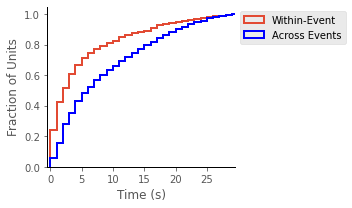

In [5]:
fig, ax = plt.subplots(1, figsize = (5,3))

ax.hist(withinint_timingall, bins = np.arange(0, 30.5, 1), histtype = 'step', cumulative = True, density = True, lw = 2)
ax.hist(withinneu_timingall, bins = np.arange(0,30.5,1), color = 'blue', histtype = 'step', cumulative = True, density = True, lw = 2)
ax.grid(False)

ax.set_facecolor('white')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')

ax.set_xlim(-.5, 29.5)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Fraction of Units')

ax.legend(('Within-Event', 'Across Events'), bbox_to_anchor=(1,1))
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('F:/Figure3_New/CumulativeDistribution_FiringTimes.png', dpi = 300)
plt.savefig('F:/Figure3_New/CumulativeDistribution_FiringTimes.svg', format = 'svg', dpi = 500, transparent = True)

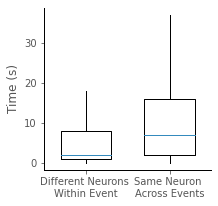

In [6]:
fig, ax = plt.subplots(1, figsize = (3,3))

ax.boxplot((withinint_timingall, withinneu_timingall), positions = (1,2), showcaps = False, showfliers = False, widths = 0.6)

ax.set_facecolor('white')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.set_ylabel('Time (s)')

ax.set_xticklabels(('Different Neurons \nWithin Event', 'Same Neuron \nAcross Events'))
plt.grid(False)
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('F:/Figure3_New/Boxplot_FiringTimes.png', dpi = 300)
plt.savefig('F:/Figure3_New/Boxplot_FiringTimes.svg', format = 'svg', dpi = 500, transparent = True)

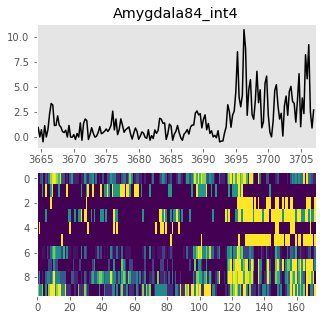

In [7]:
#### edit code to calculate time of population start


ratID = ['Amygdala6', 'Amygdala8', 'Amygdala10', 'Amygdala11']
dates = ['13042019', '01102019', '27062020', '06072020']

savedir = 'F:/FiringStartAnalysis/'
func_format.foldercheck(savedir)
intvalues = np.loadtxt('F:/InteractionPresentation_synctimes.csv', delimiter = ',', dtype = str)
neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)

relationship_firingvelocity = []
relationship_firingstimvelocity = []
relationship_firinginterd = []
relationship_firingheadd = []

normzscorefiring = []

for r, rat in enumerate(ratID):
    date = dates[r]
    
    configpath = 'F:/'+rat+'/Parameters_'+date+'.yml'
    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    neuronpath = 'F:/'+rat+'/Electrophys/'+date+'/SpikeTimes/Neurons_BLA/'
    
    neuronprofile2 = neuronprofile[neuronprofile[:,0] == rat]
    intvalues2 = intvalues[intvalues[:,0] == rat]
    
    behavioralvalues = np.loadtxt('F:/'+rat+'/TrackingData/'+date+'_rat1values.csv', delimiter = ',', dtype = str)
    
    for f, folder in enumerate(foldername):
                
        inte = np.ravel(intvalues2[intvalues2[:,2] == folder])
        presentationstart = np.float32(inte[3])
        presentationstop = np.float32(inte[5])
        contactstart = np.float32(inte[7])
        
        if inte[6] == 'nan':
            approach = 'passive'
        else:
            approach = 'active'
        
        if intcat[f] == 'Object':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'object') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'object') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]
            
        elif intcat[f] == 'Male':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'male') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'male') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]

        elif intcat[f] == 'Female':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'female') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'female') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]

        elif intcat[f] == 'Food':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'food') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'food') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]
            
        if rat != 'Amygdala8':
            continue
        if folder != '4_int4':
            continue
        
        neurontypeall = []
        for n, neu in enumerate(neuronlist):
            neuron = np.float_(np.load('F:/'+rat+'/Electrophys/'+date+'/SpikeTimes/Neurons_BLA/'+neu+'.npy')/1000)
            [zscore_fr, bins] = calculate_zscore(neuron, presentationstart-2, contactstart+2.1, presentationstart-300, presentationstart, .25)
            indneurontype = neurontype[n]
            neurontypeall = np.append(neurontypeall, indneurontype)
            
            savepresentationstart = presentationstart
            savepresentationstop = presentationstop
            savecontact = contactstart 
            
            
            if n == 0:
                interaction_zscorefr = zscore_fr
            else:
                interaction_zscorefr = np.vstack((interaction_zscorefr, zscore_fr))
                
                
        indexstart = np.argmin(np.abs(np.array(behavioralvalues[0,1:], np.float) - (presentationstop-10))+1)
        indexstop = np.argmin(np.abs(np.array(behavioralvalues[0,1:], np.float) - (contactstart+10))+1)
        
        tailvelocity = np.array(behavioralvalues[2,indexstart:indexstop], np.float)
        stimulusvelocity= np.array(behavioralvalues[5,indexstart:indexstop], np.float)
        interd_head = np.array(behavioralvalues[6,indexstart:indexstop], np.float)
        headd_head = np.array(behavioralvalues[8,indexstart:indexstop], np.float)
        sync = np.array(behavioralvalues[0,indexstart:indexstop], np.float)
        
        
        
        try:
            removelowfiring = np.where(np.max(interaction_zscorefr[:,8:-8], axis = 1) < 2)
            interaction_zscorefr_2 = np.delete(interaction_zscorefr, removelowfiring, axis = 0)
            norm_zscorefr = interaction_zscorefr_2/np.max(interaction_zscorefr_2, axis = 1).reshape(-1,1)
        except:
            continue
        plt.close()
        
        fig, ax = plt.subplots(2, figsize = (5,5))
        
        ax[0].plot(bins[:-1], np.mean(interaction_zscorefr_2, axis = 0), color = 'k')
        ax[1].imshow(interaction_zscorefr_2, aspect = 'auto', interpolation = 'None', vmin = 0, vmax = 5)
        
        ax[0].grid(False)
        ax[1].grid(False)
        ax[0].set_xlim((presentationstart-2, contactstart+2))
        ax[0].set_title(rat + folder)
        
        plt.show()
        break
        
        
        
        
        #fig, ax = plt.subplots(5, figsize = (5, 5), sharex = True)

        #ax[0].plot(sync, tailvelocity)
        #ax[1].plot(sync, stimulusvelocity)
        #ax[2].plot(sync, interd_head)
        #ax[3].plot(sync, headd_head)
        #ax[4].plot(bins[:-1], np.mean(interaction_zscorefr, axis = 0))

        #ax[4].set_xlim(bins[0], bins[-1])
        
        #if np.max(np.mean(interaction_zscorefr, axis = 0)) > 5:
            #ax[4].vlines(bins[np.argmax(np.mean(interaction_zscorefr, axis = 0))], ymin = 0, ymax = np.max(np.mean(interaction_zscorefr, axis = 0)), color = 'k')
            #ax[0].vlines(sync[np.argmax(tailvelocity)], ymin = 0, ymax = np.max(tailvelocity), color = 'k')
        
        
            #firingpeak = bins[np.nanargmax(np.mean(interaction_zscorefr, axis = 0))]
            #velocitypeak = sync[np.nanargmax(tailvelocity)]
            #relationship_firingvelocity = np.append(relationship_firingvelocity, firingpeak-velocitypeak)
            #try:
                #stimulusvelocitypeak = sync[np.nanargmax(stimulusvelocity)]
                #interd_headmin = sync[np.nanargmin(interd_head)]
                #headd_min = sync[np.nanargmin(headd_head)]
                #relationship_firingstimvelocity = np.append(relationship_firingstimvelocity, firingpeak-stimulusvelocitypeak)
                #relationship_firinginterd = np.append(relationship_firinginterd, firingpeak-interd_headmin)
                #relationship_firingheadd = np.append(relationship_firingheadd, firingpeak-headd_min)
            #except:
                #continue

            
            
            
       
            
        

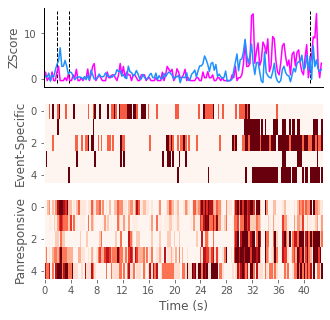

In [9]:
fig, ax = plt.subplots(3, figsize = (5,5))

ax[0].plot(np.mean(interaction_zscorefr_2[neurontypeall != 'panresponsive'], axis = 0), color = 'magenta')
ax[0].plot(np.mean(interaction_zscorefr_2[neurontypeall == 'panresponsive'], axis = 0), color = 'dodgerblue')
ax[1].imshow(interaction_zscorefr_2[neurontypeall != 'panresponsive'], aspect = 'auto', interpolation = 'None', vmin = 0, vmax = 5, cmap = 'Reds')
ax[2].imshow(interaction_zscorefr_2[neurontypeall == 'panresponsive'], aspect = 'auto', interpolation = 'None', vmin = 0, vmax = 5, cmap = 'Reds')

ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)

ax[0].set_xlim(0, 172)

ax[0].set_facecolor('white')
ax[0].set_xticks([])
ax[1].set_xticks([])

ax[2].set_xticks(np.arange(0,170,16))
ax[2].set_xticklabels((np.arange(0, 44, 4)))

ax[0].vlines(8, ymin = -1, ymax = 15, linestyle = '--', color = 'k', lw = 1)
ax[0].vlines(8+1.8*4, ymin = -1, ymax = 15, linestyle = '--', color = 'k', lw = 1)
ax[0].vlines(172-8, ymin = -1, ymax = 15, linestyle = '--', color = 'k', lw = 1)

ax[2].set_xlabel('Time (s)')
ax[0].set_ylabel('ZScore')
ax[1].set_ylabel('Event-Specific')
ax[2].set_ylabel('Panresponsive')
ax[0].spines['left'].set_color('k')
ax[0].spines['bottom'].set_color('k')

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('F:/Figure3_New/Example_EventOnset.png', dpi = 300)
plt.savefig('F:/Figure3_New/Example_EventOnset.svg', format = 'svg', dpi = 500, transparent = True)

In [214]:
##### time lag between approach and neuronal firing
##### add random jitter to the approach timing and repeat analysis


ratID = ['Amygdala6', 'Amygdala8', 'Amygdala10', 'Amygdala11']
dates = ['13042019', '01102019', '27062020', '06072020']

savedir = 'F:/FiringStartAnalysis/'
func_format.foldercheck(savedir)
intvalues = np.loadtxt('F:/InteractionPresentation_synctimes.csv', delimiter = ',', dtype = str)
neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)
distanceheadall =np.zeros(10)
velocityall = np.zeros(10)
distancetailall = np.zeros(10)
headdtoheadall = np.zeros(10)
headdtotailall = np.zeros(10)
timeofmaxfiringall = np.zeros(10)
timeafterstartall = np.zeros(10)
timebeforecontactall = np.zeros(10)
fraction_timeafterstartall = np.zeros(10)
timerelativetoapproachall = np.zeros(10)
timerandrelativetoapproachall = np.zeros(10)

distancerat = []
velocityrat = []
distancetailrat = []
headdtoheadrat = []
headdtotailrat = []
allpossibletimes_relativetoneuron = []
normzscorefiring = []
randomjitter = np.arange(-5, 5, 1)
zscorefr_approachall = np.zeros(80)

for r, rat in enumerate(ratID):
    date = dates[r]
    
    configpath = 'F:/'+rat+'/Parameters_'+date+'.yml'
    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    neuronpath = 'F:/'+rat+'/Electrophys/'+date+'/SpikeTimes/Neurons_BLA/'
    
    neuronprofile2 = neuronprofile[neuronprofile[:,0] == rat]
    intvalues2 = intvalues[intvalues[:,0] == rat]
    
    
    for f, folder in enumerate(foldername):
                
        inte = np.ravel(intvalues2[intvalues2[:,2] == folder])
        presentationstart = np.float32(inte[3])
        presentationstop = np.float32(inte[5])
        contactstart = np.float32(inte[7])
        
        if inte[6] == 'nan':
            approach = 'passive'
            continue
        else:
            approach = 'active'
            approachtime = np.float32(inte[6])
        
        if intcat[f] == 'Object':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'object') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'object') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]
            
        elif intcat[f] == 'Male':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'male') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'male') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]

        elif intcat[f] == 'Female':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'female') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'female') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]

        elif intcat[f] == 'Food':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'food') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'food') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]
        
        for n, neu in enumerate(neuronlist):
            neuron = np.float_(np.load('F:/'+rat+'/Electrophys/'+date+'/SpikeTimes/Neurons_BLA/'+neu+'.npy')/1000)
            [zscore_fr, bins] = calculate_zscore(neuron, presentationstop, contactstart, presentationstart-300, presentationstart, 1)
            indneurontype = neurontype[n]
            
            try:
                if np.max(zscore_fr) < 2:
                    continue
            except:
                continue
                
            zscorefr_norm = zscore_fr/np.max(zscore_fr)
            
            normzscorefiring.append([zscorefr_norm])
            index = bins[np.argmax(zscorefr_norm)]
            
            
            #try:
                #index = np.ravel(bins[np.where(zscore_fr > 2)])[0]
            #except:
                #continue
            indexsync = np.argmin(np.abs(np.array(behavioralvalues[0,1:], np.float) - index))+1
            indexstart = np.argmin(np.abs(np.array(behavioralvalues[0,1:], np.float) - presentationstop))+1
            indexstop = np.argmin(np.abs(np.array(behavioralvalues[0,1:], np.float) - (contactstart)))+1
            
            
            timeofmaxfiring = [rat, date, folder, neu, intcat[f], inttype[f], presentationnum[f], approach, indneurontype, index]
            timerelativetoapproach = [rat, date, folder, neu, intcat[f], inttype[f], presentationnum[f], approach, indneurontype, approachtime-index]
            
            allpossibletimes = np.arange(presentationstop, contactstart, 1)
            
            for x, xx in enumerate(allpossibletimes):
                
                allpossibletimes_relativetoneuron = np.append(allpossibletimes_relativetoneuron, xx-index)
                
                
            [zscorefr_approach, bins2] = calculate_zscore(neuron, approachtime-10, approachtime+10.1, presentationstart-300, presentationstart, .25)
            
            zscorefr_approachall = np.vstack((zscorefr_approachall, zscorefr_approach))
            
            
            #randapproachdelay = []
            #for x in range(100):
                #randchoice = np.random.choice(randomjitter)
                
                #approachtimerand = approachtime+randchoice
                #randapproachdelay = np.append(randapproachdelay, approachtimerand-index)
                
            #timerandrelativetoapproach = [rat, date, folder, neu, intcat[f], inttype[f], presentationnum[f], approach, indneurontype, np.mean(randapproachdelay)]
                
            
            timeofmaxfiringall = np.vstack((timeofmaxfiringall, timeofmaxfiring))
            timerelativetoapproachall = np.vstack((timerelativetoapproachall, timerelativetoapproach))
            #timerandrelativetoapproachall = np.vstack((timerandrelativetoapproachall, timerandrelativetoapproach))
            
zscorefr_approachall = zscorefr_approachall[1:]
timeofmaxfiringall = timeofmaxfiringall[1:]
timerelativetoapproachall = timerelativetoapproachall[1:]
#timerandrelativetoapproachall = timerandrelativetoapproachall[1:]

       
            
        

In [256]:
zscorefr_approachpan = zscorefr_approachall[timerelativetoapproachall[:,-2] == 'panresponsive']
zscorefr_approachuni = zscorefr_approachall[timerelativetoapproachall[:,-2] != 'panresponsive']

sortorderpan = np.argsort(np.max(zscorefr_approachpan, axis = 1))
sorted_zscorefrpan_approach = np.take_along_axis(zscorefr_approachpan, sortorderpan.reshape(-1,1), axis = 0)

sortorderuni = np.argsort(np.max(zscorefr_approachuni, axis = 1))
sorted_zscorefruni_approach = np.take_along_axis(zscorefr_approachuni, sortorderuni.reshape(-1,1), axis = 0)

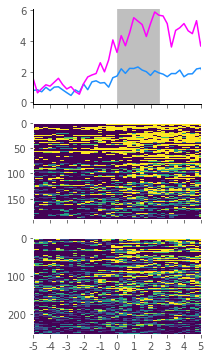

In [262]:
fig, ax = plt.subplots(3, sharex = True, figsize = (3, 6))

ax[0].plot(np.mean(sorted_zscorefrpan_approach, axis = 0), color = 'dodgerblue')
ax[0].plot(np.mean(sorted_zscorefruni_approach, axis = 0), color = 'magenta')

ax[1].imshow(np.flip(sorted_zscorefruni_approach, axis = 0), aspect = 'auto', interpolation = 'None', vmin = 0, vmax = 5)
ax[2].imshow(np.flip(sorted_zscorefrpan_approach, axis = 0), aspect = 'auto', interpolation = 'None', vmin = 0, vmax = 5)


ax[1].grid(False)
ax[2].grid(False)

ax[2].set_xlim((20, 60))
ax[2].set_xticks((np.arange(20, 61, 4)))
ax[2].set_xticklabels((np.arange(-5, 6)))

ax[0].axvspan(40, 50, color = 'gray', alpha = 0.5)
ax[0].grid(False)

ax[0].set_facecolor('white')
ax[0].spines['left'].set_color('k')
ax[0].spines['bottom'].set_color('k')

plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('F:/Figure3_New/FiringTiedtoApproach.png', dpi = 300)
plt.savefig('F:/Figure3_New/FiringTiedtoApproach.svg', format = 'svg', dpi = 500, transparent = True)

In [254]:
zscorefr_approachall[timerelativetoapproachall[:,-2] == 'panresponsive']

array([[ 2.26 ,  0.292, -0.692, ...,  3.244, -0.692, -1.676],
       [ 2.399, -0.672,  0.352, ..., -1.695,  1.375, -0.672],
       [-0.094, -0.094, -0.094, ..., -0.094, -0.094, -0.094],
       ...,
       [ 0.513,  0.513,  2.525, ..., -0.157,  2.525,  2.525],
       [-1.159, -1.159, -1.159, ..., -1.159,  1.378,  3.915],
       [-0.1  ,  0.581,  2.622, ...,  1.942,  3.983,  4.664]])

In [163]:
#### edit code to calculate time of population start


ratID = ['Amygdala6', 'Amygdala8', 'Amygdala10', 'Amygdala11']
dates = ['13042019', '01102019', '27062020', '06072020']

savedir = 'F:/FiringStartAnalysis/'
func_format.foldercheck(savedir)
intvalues = np.loadtxt('F:/InteractionPresentation_synctimes.csv', delimiter = ',', dtype = str)
neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)

relationship_firingvelocity = []
relationship_firingstimvelocity = []
relationship_firinginterd = []
relationship_firingheadd = []

normzscorefiring = []

for r, rat in enumerate(ratID):
    date = dates[r]
    
    configpath = 'F:/'+rat+'/Parameters_'+date+'.yml'
    [foldername, inttype, intcat, presentationnum, videosync_start, videosync_stop, framerate, framestouse, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    neuronpath = 'F:/'+rat+'/Electrophys/'+date+'/SpikeTimes/Neurons_BLA/'
    
    neuronprofile2 = neuronprofile[neuronprofile[:,0] == rat]
    intvalues2 = intvalues[intvalues[:,0] == rat]
    
    behavioralvalues = np.loadtxt('F:/'+rat+'/TrackingData/'+date+'_rat1values.csv', delimiter = ',', dtype = str)
    
    for f, folder in enumerate(foldername):
                
        inte = np.ravel(intvalues2[intvalues2[:,2] == folder])
        presentationstart = np.float32(inte[3])
        presentationstop = np.float32(inte[5])
        contactstart = np.float32(inte[7])
        
        if inte[6] == 'nan':
            approach = 'passive'
        else:
            approach = 'active'
        
        if intcat[f] == 'Object':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'object') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'object') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]
            
        elif intcat[f] == 'Male':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'male') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'male') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]

        elif intcat[f] == 'Female':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'female') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'female') | (neuronprofile2[:,4] == 'social') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]

        elif intcat[f] == 'Food':
            neuronlist = neuronprofile2[np.where((neuronprofile2[:,4] == 'food') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,2]
            neurontype = neuronprofile2[np.where((neuronprofile2[:,4] == 'food') | (neuronprofile2[:,4] == 'nonsocial') | (neuronprofile2[:,4] == 'panresponsive'))][:,4]
            
        if rat != 'Amygdala8':
            continue
        if folder != '4_int4':
            continue
        
        neurontypeall = []
        for n, neu in enumerate(neuronlist):
            neuron = np.float_(np.load('F:/'+rat+'/Electrophys/'+date+'/SpikeTimes/Neurons_BLA/'+neu+'.npy')/1000)
            [zscore_fr, bins] = calculate_zscore(neuron, presentationstart-2, contactstart+2.1, presentationstart-300, presentationstart, .25)
            indneurontype = neurontype[n]
            neurontypeall = np.append(neurontypeall, indneurontype)
            
            savepresentationstart = presentationstart
            savepresentationstop = presentationstop
            savecontact = contactstart 
            
            
            if n == 0:
                interaction_zscorefr = zscore_fr
            else:
                interaction_zscorefr = np.vstack((interaction_zscorefr, zscore_fr))
                
                
        indexstart = np.argmin(np.abs(np.array(behavioralvalues[0,1:], np.float) - (presentationstop-10))+1)
        indexstop = np.argmin(np.abs(np.array(behavioralvalues[0,1:], np.float) - (contactstart+10))+1)
        
        tailvelocity = np.array(behavioralvalues[2,indexstart:indexstop], np.float)
        stimulusvelocity= np.array(behavioralvalues[5,indexstart:indexstop], np.float)
        interd_head = np.array(behavioralvalues[6,indexstart:indexstop], np.float)
        headd_head = np.array(behavioralvalues[8,indexstart:indexstop], np.float)
        sync = np.array(behavioralvalues[0,indexstart:indexstop], np.float)
        
        
        
        try:
            removelowfiring = np.where(np.max(interaction_zscorefr[:,8:-8], axis = 1) < 2)
            interaction_zscorefr_2 = np.delete(interaction_zscorefr, removelowfiring, axis = 0)
            norm_zscorefr = interaction_zscorefr_2/np.max(interaction_zscorefr_2, axis = 1).reshape(-1,1)
        except:
            continue
        plt.close()
        
        fig, ax = plt.subplots(2, figsize = (5,5))
        
        ax[0].plot(bins[:-1], np.mean(interaction_zscorefr_2, axis = 0), color = 'k')
        ax[1].imshow(interaction_zscorefr_2, aspect = 'auto', interpolation = 'None', vmin = 0, vmax = 5)
        
        ax[0].grid(False)
        ax[1].grid(False)
        ax[0].set_xlim((presentationstart-2, contactstart+2))
        ax[0].set_title(rat + folder)
        
        plt.show()
        break
        
        
        
        
        #fig, ax = plt.subplots(5, figsize = (5, 5), sharex = True)

        #ax[0].plot(sync, tailvelocity)
        #ax[1].plot(sync, stimulusvelocity)
        #ax[2].plot(sync, interd_head)
        #ax[3].plot(sync, headd_head)
        #ax[4].plot(bins[:-1], np.mean(interaction_zscorefr, axis = 0))

        #ax[4].set_xlim(bins[0], bins[-1])
        
        #if np.max(np.mean(interaction_zscorefr, axis = 0)) > 5:
            #ax[4].vlines(bins[np.argmax(np.mean(interaction_zscorefr, axis = 0))], ymin = 0, ymax = np.max(np.mean(interaction_zscorefr, axis = 0)), color = 'k')
            #ax[0].vlines(sync[np.argmax(tailvelocity)], ymin = 0, ymax = np.max(tailvelocity), color = 'k')
        
        
            #firingpeak = bins[np.nanargmax(np.mean(interaction_zscorefr, axis = 0))]
            #velocitypeak = sync[np.nanargmax(tailvelocity)]
            #relationship_firingvelocity = np.append(relationship_firingvelocity, firingpeak-velocitypeak)
            #try:
                #stimulusvelocitypeak = sync[np.nanargmax(stimulusvelocity)]
                #interd_headmin = sync[np.nanargmin(interd_head)]
                #headd_min = sync[np.nanargmin(headd_head)]
                #relationship_firingstimvelocity = np.append(relationship_firingstimvelocity, firingpeak-stimulusvelocitypeak)
                #relationship_firinginterd = np.append(relationship_firinginterd, firingpeak-interd_headmin)
                #relationship_firingheadd = np.append(relationship_firingheadd, firingpeak-headd_min)
            #except:
                #continue

            
            
            
       
            
        

1.8000488

In [155]:
bins[0]

3664.262451171875

In [191]:
timeafterstart_pan = timeafterstartall[timeafterstartall[:,-2] == 'panresponsive']
timeafterstart_uni = timeafterstartall[timeafterstartall[:,-2] != 'panresponsive']

In [192]:
idinfoint_pan = []
for i, row in enumerate(timeafterstart_pan):
    idinfoint_pan = np.hstack((idinfoint_pan, row[0]+row[1]+row[2]))
    
idinfoneu_pan = []
for i, row in enumerate(timeafterstart_pan):
    idinfoneu_pan = np.hstack((idinfoneu_pan, row[0]+row[1]+row[3]))
    
idinfoint_uni = []
for i, row in enumerate(timeafterstart_uni):
    idinfoint_uni = np.hstack((idinfoint_uni, row[0]+row[1]+row[2]))
    
idinfoneu_uni = []
for i, row in enumerate(timeafterstart_uni):
    idinfoneu_uni = np.hstack((idinfoneu_uni, row[0]+row[1]+row[3]))

uniqueints_pan = np.unique(idinfoint_pan)
uniqueneus_pan = np.unique(idinfoneu_pan)
uniqueints_uni = np.unique(idinfoint_uni)
uniqueneus_uni = np.unique(idinfoneu_uni)

withinint_timingpan = []
for i, inte in enumerate(uniqueints_pan):
    
    info = timeafterstart_pan[idinfoint_pan == inte]
    firingtimeperint = np.array(info[:,-1], np.float)
    
    withint_firingdpan = spatial.distance.pdist(firingtimeperint.reshape(-1,1))
    withinint_timingpan = np.append(withinint_timingpan, withint_firingdpan)
    
withinint_timinguni = []
for i, inte in enumerate(uniqueints_uni):
    
    info = timeafterstart_uni[idinfoint_uni == inte]
    firingtimeperint = np.array(info[:,-1], np.float)
    
    withint_firingduni = spatial.distance.pdist(firingtimeperint.reshape(-1,1))
    withinint_timinguni = np.append(withinint_timinguni, withint_firingduni)
    
withinneu_timingpan = []
for i, neu in enumerate(uniqueneus_pan):
    
    info = timeafterstart_pan[idinfoneu_pan == neu]
    firingtimeperneu = np.array(info[:,-1], np.float)
    
    withinneu_firingdpan = spatial.distance.pdist(firingtimeperneu.reshape(-1,1))
    withinneu_timingpan = np.append(withinneu_timingpan, withinneu_firingdpan)
    
withinneu_timinguni = []
for i, neu in enumerate(uniqueneus_uni):
    
    info = timeafterstart_uni[idinfoneu_uni == neu]
    firingtimeperneu = np.array(info[:,-1], np.float)
    
    withinneu_firingduni = spatial.distance.pdist(firingtimeperneu.reshape(-1,1))
    withinneu_timinguni = np.append(withinneu_timinguni, withinneu_firingduni)

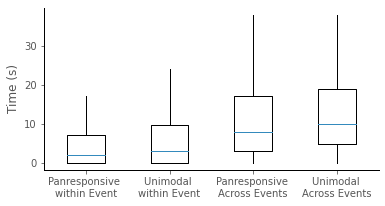

In [193]:
fig, ax = plt.subplots(1, figsize = (6,3))

ax.boxplot((withinint_timingpan, withinint_timinguni, withinneu_timingpan, withinneu_timinguni), positions = (1,2,3,4), showcaps = False, showfliers = False)

ax.set_facecolor('white')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.set_ylabel('Time (s)')

ax.set_xticklabels(('Panresponsive \nwithin Event', 'Unimodal \nwithin Event', 'Panresponsive \nAcross Events', 'Unimodal \nAcross Events'))
plt.grid(False)

In [194]:
timeafterstart_male = timeafterstartall[timeafterstartall[:,4] == 'Male']
timeafterstart_female = timeafterstartall[timeafterstartall[:,4] == 'Female']
timeafterstart_obj = timeafterstartall[timeafterstartall[:,4] == 'Object']
timeafterstart_food = timeafterstartall[timeafterstartall[:,4] == 'Food']

In [195]:
idinfoint_male = []
for i, row in enumerate(timeafterstart_male):
    idinfoint_male = np.hstack((idinfoint_male, row[0]+row[1]+row[2]))
    
idinfoint_female = []
for i, row in enumerate(timeafterstart_female):
    idinfoint_female = np.hstack((idinfoint_female, row[0]+row[1]+row[2]))
    
idinfoint_obj = []
for i, row in enumerate(timeafterstart_obj):
    idinfoint_obj = np.hstack((idinfoint_obj, row[0]+row[1]+row[2]))
    
idinfoint_food = []
for i, row in enumerate(timeafterstart_food):
    idinfoint_food = np.hstack((idinfoint_food, row[0]+row[1]+row[2]))
    
uniqueints_male = np.unique(idinfoint_male)
uniqueints_female = np.unique(idinfoint_female)
uniqueints_obj = np.unique(idinfoint_obj)
uniqueints_food = np.unique(idinfoint_food)

withint_timingmale = []
for i, inte in enumerate(uniqueints_male):
    info = timeafterstart_male[idinfoint_male == inte]
    firingtimeperint = np.array(info[:,-1], np.float)
    
    withint_firingdmale = spatial.distance.pdist(firingtimeperint.reshape(-1,1))
    withint_timingmale = np.append(withint_timingmale, withint_firingdmale)
    
withint_timingfemale = []
for i, inte in enumerate(uniqueints_female):
    info = timeafterstart_female[idinfoint_female == inte]
    firingtimeperint = np.array(info[:,-1], np.float)
    
    withint_firingdfemale = spatial.distance.pdist(firingtimeperint.reshape(-1,1))
    withint_timingfemale = np.append(withint_timingfemale, withint_firingdfemale)
    
withint_timingobj = []
for i, inte in enumerate(uniqueints_obj):
    info = timeafterstart_obj[idinfoint_obj == inte]
    firingtimeperint = np.array(info[:,-1], np.float)
    
    withint_firingdobj = spatial.distance.pdist(firingtimeperint.reshape(-1,1))
    withint_timingobj = np.append(withint_timingobj, withint_firingdobj)
    
withint_timingfood = []
for i, inte in enumerate(uniqueints_food):
    info = timeafterstart_food[idinfoint_food == inte]
    firingtimeperint = np.array(info[:,-1], np.float)
    
    withint_firingdfood = spatial.distance.pdist(firingtimeperint.reshape(-1,1))
    withint_timingfood = np.append(withint_timingfood, withint_firingdfood)

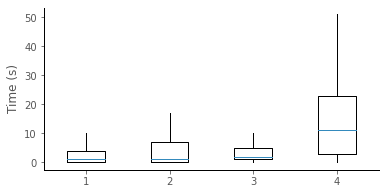

In [196]:
fig, ax = plt.subplots(1, figsize = (6,3))

ax.boxplot((withint_timingmale, withint_timingfemale, withint_timingobj, withint_timingfood), positions = (1,2,3,4), showcaps = False, showfliers = False)

ax.set_facecolor('white')
ax.spines['left'].set_color('k')
ax.spines['bottom'].set_color('k')
ax.set_ylabel('Time (s)')

#ax.set_xticklabels(('Panresponsive \nwithin Event', 'Unimodal \nwithin Event', 'Panresponsive \nAcross Events', 'Unimodal \nAcross Events'))
plt.grid(False)

(array([ 2.,  2.,  6., 11., 17.,  4.,  2.,  2.,  1.,  1.]),
 array([-25.652, -19.264, -12.877,  -6.489,  -0.101,   6.286,  12.674,
         19.062,  25.449,  31.837,  38.225]),
 <BarContainer object of 10 artists>)

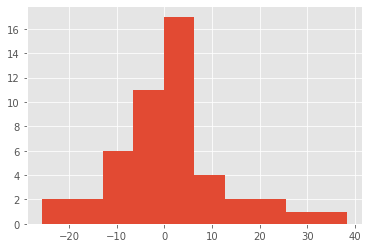

In [284]:
plt.hist(relationship_firingvelocity)

(array([ 1.,  2.,  6., 11., 11.,  1.,  3.,  3.,  0.,  2.]),
 array([-17.875, -13.417,  -8.96 ,  -4.502,  -0.045,   4.413,   8.87 ,
         13.328,  17.785,  22.243,  26.7  ]),
 <BarContainer object of 10 artists>)

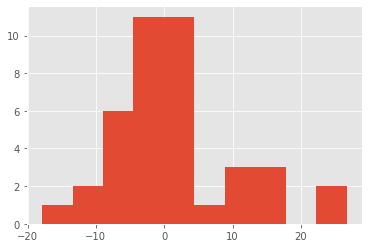

In [285]:
plt.hist(relationship_firingstimvelocity)

(array([ 2.,  2.,  0.,  5.,  3.,  7., 10.,  5.,  2.,  4.]),
 array([-18.193, -15.476, -12.76 , -10.043,  -7.326,  -4.609,  -1.892,
          0.825,   3.542,   6.258,   8.975]),
 <BarContainer object of 10 artists>)

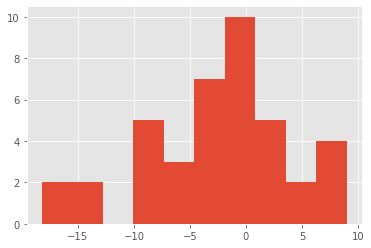

In [286]:
plt.hist(relationship_firinginterd)

(array([1., 0., 6., 8., 8., 6., 4., 4., 2., 1.]),
 array([-20.775, -16.462, -12.15 ,  -7.837,  -3.525,   0.787,   5.1  ,
          9.412,  13.725,  18.037,  22.35 ]),
 <BarContainer object of 10 artists>)

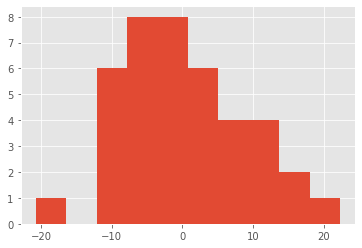

In [287]:
plt.hist(relationship_firingheadd)

In [ ]:
indexstart = np.argmin(np.abs(np.array(behavioralvalues[0,1:], np.float) - presentationstop))+1
indexstop = np.argmin(np.abs(np.array(behavioralvalues[0,1:], np.float) - (contactstart)))+1

In [212]:
def plotsocialnonsocial(zfr, normfr, interaction, behavior, colortouse, savepath):
    plt.close()
    fig = plt.figure(figsize = (6, 3))
    gs = gridspec.GridSpec(nrows = 2, ncols = 1, height_ratios=[1,2])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])
    
    for i, row in enumerate(interaction-(behavior['intstart']-10)):
        ax0.axvspan(row[0]*10, row[1]*10, color = colortouse, alpha = 0.3)
        ax1.axvspan(row[0]*10, row[1]*10, color = colortouse, alpha = 0.3)
        
    meanfr = convolve(np.mean(zfr, axis = 0), Gaussian1DKernel(np.sqrt(10)))
    stdfr = convolve(stats.sem(zfr, axis = 0), Gaussian1DKernel(np.sqrt(10)))
    ax0.plot(meanfr, color = 'black', lw = 1)
    ax0.fill_between(np.arange(0, len(meanfr)), meanfr-stdfr, meanfr+stdfr, color = 'grey')
    normfr_sorted = np.take_along_axis(normfr, np.flip(sortorder.reshape(len(sortorder), 1)), axis = 0)
    ax1.imshow(normfr_sorted, aspect = 'auto', vmax = 0.5, cmap = 'Greys')
    
    ax0.grid(False)
    ax1.grid(False)
    lastbin = np.int((np.float(behavior['intstop'])+30 - (np.float(behavior['intstart'])))*10)
    
    ax1.set_xlim((0, lastbin))
    ax0.set_xlim((0, lastbin))
    
    ax0.set_facecolor('white')
    ax1.set_facecolor('white')
    ax0.spines['left'].set_color('k')
    ax0.spines['bottom'].set_color('k')
    
    ax1.set_xticks((np.arange(0, lastbin, 600)))
    ax1.set_xticklabels((np.arange(0, lastbin, 600))/10)
    
    plt.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(savepath, format = 'svg', dpi = 500, transparent = True)

array(['Amygdala11', '06072020', '15_int14', '15040.884033333334',
       '15043.1342', '15045.409211111111', 'nan', '15051.534066666667',
       '15352.733483333333', '15353.983400000001', '15355.758433333333'],
      dtype='<U22')

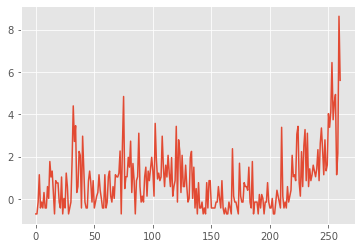

In [211]:
plt.plot(np.mean(interaction_zscorefr, axis = 0))

In [205]:
interaction_zscorefr.shape

(5, 6)

In [206]:
interaction_zscorefr

array([[ 1.837, -0.441, -0.441, -0.441, -0.441, -0.441],
       [ 4.935,  1.653,  4.935,  4.935, -0.535, -1.629],
       [ 5.978,  6.624,  5.978,  2.106,  0.17 ,  0.815],
       [ 2.623,  2.159,  3.319,  0.072,  0.304,  0.304],
       [-0.587, -0.587, -0.587, -0.587, -0.587, -0.587]])

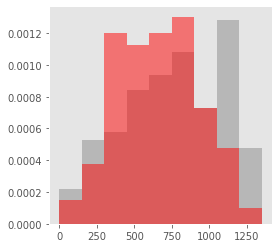

In [313]:
plt.close()

alldistances = np.array(distancerat, float)
neuronstartdistances = np.array(distanceheadall[:,-1], float)
bins = np.arange(0, 1401, 150)

fig, ax = plt.subplots(1, figsize = (4, 4))

ax.hist(alldistances, density = True, alpha = 0.2, color = 'k', bins = bins)
ax.hist(neuronstartdistances, density = True, alpha = 0.5, color = 'red', bins = bins)
ax.grid(False)

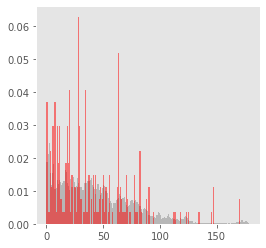

In [327]:

plt.close()

alldistances = np.array(headdtoheadrat, float)
neuronstartdistances = np.array(headdtoheadall[:,-1], float)
bins = np.arange(0, 180, 1)

fig, ax = plt.subplots(1, figsize = (4, 4))

ax.hist(alldistances, density = True, alpha = 0.2, color = 'k', bins = bins)
ax.hist(neuronstartdistances, density = True, alpha = 0.5, color = 'red', bins = bins)
ax.grid(False)

In [315]:
male = distanceheadall[distanceheadall[:,4] == 'Male']
female = distanceheadall[distanceheadall[:,4] == 'Female']
obj = distanceheadall[distanceheadall[:,4] == 'Object']
food = distanceheadall[distanceheadall[:,4] == 'Food']

(array([ 2.,  2.,  9., 11.,  1., 25.,  3.,  0.,  0.]),
 array([   0,  150,  300,  450,  600,  750,  900, 1050, 1200, 1350]),
 <a list of 9 Patch objects>)

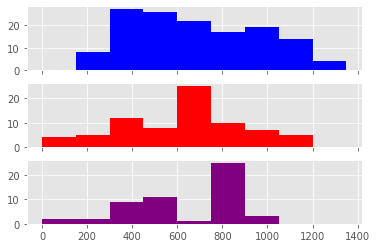

In [316]:
fig, ax = plt.subplots(3, sharex = True)

ax[0].hist(np.array(male[:,-1], float), color = 'blue', bins = bins)
ax[1].hist(np.array(female[:,-1], float), color = 'red', bins = bins)
ax[2].hist(np.array(obj[:,-1], float), color = 'purple', bins = bins)
#ax[3].hist(np.array(food[:,-1], float), color = 'orange')


In [317]:
first = distanceheadall[distanceheadall[:,-4] == '1']
second = distanceheadall[distanceheadall[:,-4] == '2']

(array([ 5.,  3., 25., 19., 20., 16., 21., 14.,  3.]),
 array([   0,  150,  300,  450,  600,  750,  900, 1050, 1200, 1350]),
 <a list of 9 Patch objects>)

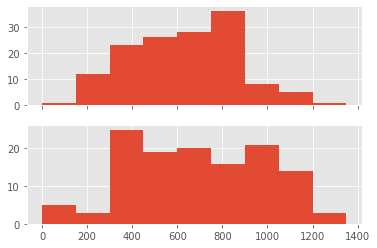

In [318]:
fig, ax = plt.subplots(2, sharex = True)

ax[0].hist(np.array(first[:,-1], float), bins = bins)
ax[1].hist(np.array(second[:,-1], float), bins = bins)

(array([ 4., 12.,  4.,  1., 12.,  5.,  5.,  2.,  2.,  5.]),
 array([ 144.015,  268.724,  393.433,  518.142,  642.851,  767.56 ,
         892.269, 1016.978, 1141.687, 1266.396, 1391.105]),
 <a list of 10 Patch objects>)

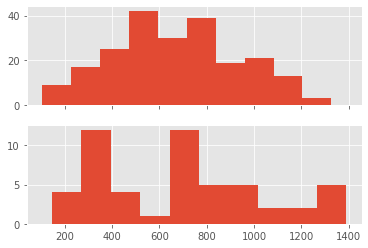

In [319]:
active = distanceheadall[distanceheadall[:,-3] == 'active']
passive = distanceheadall[distanceheadall[:,-3] == 'passive']
bins = np.arange(0, 1401, 150)

fig, ax = plt.subplots(2, sharex = True)

ax[0].hist(np.array(active[:,-1], float))
ax[1].hist(np.array(passive[:,-1], float))

(array([ 8., 19.,  8., 22., 20., 22.,  5.,  9.,  4.,  2.]),
 array([ 102.987,  231.799,  360.611,  489.423,  618.235,  747.046,
         875.858, 1004.67 , 1133.482, 1262.294, 1391.105]),
 <a list of 10 Patch objects>)

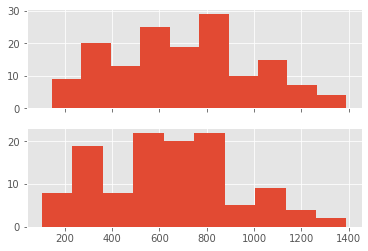

In [320]:
panresponsive = distanceheadall[distanceheadall[:,-2] == 'panresponsive']
notpanresponsive = distanceheadall[distanceheadall[:,-2] != 'panresponsive']
bins = np.arange(0, 1401, 150)

fig, ax = plt.subplots(2, sharex = True)
ax[0].hist(np.array(panresponsive[:,-1], float))
ax[1].hist(np.array(notpanresponsive[:,-1], float))

In [321]:
idinfo = []
for i, row in enumerate(distanceheadall):
    idinfo = np.hstack((idinfo, row[0]+row[1]+row[2]))

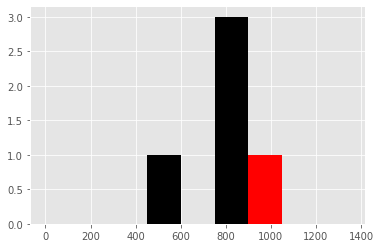

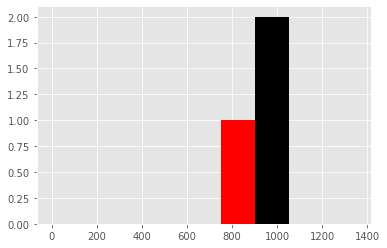

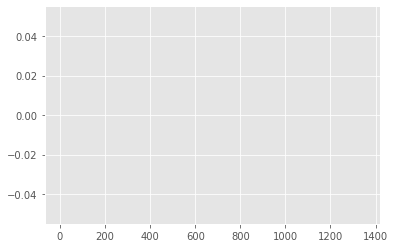

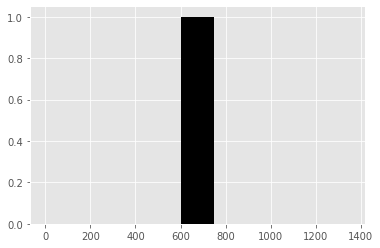

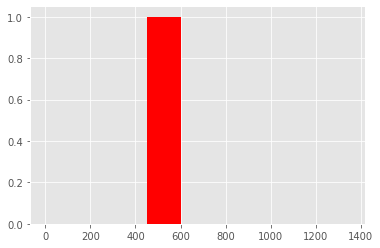

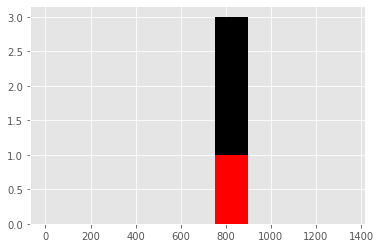

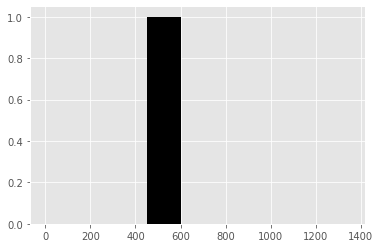

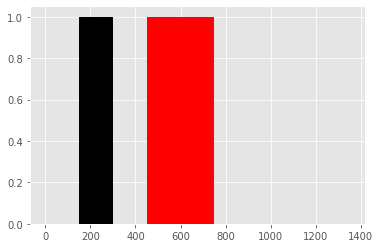

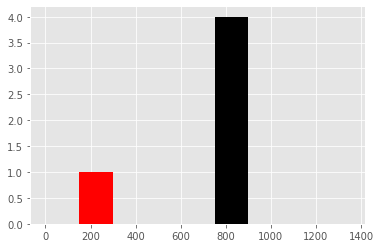

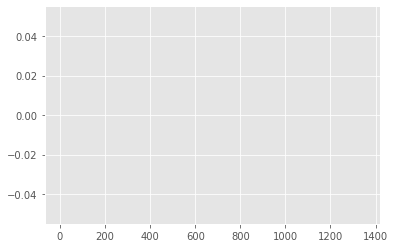

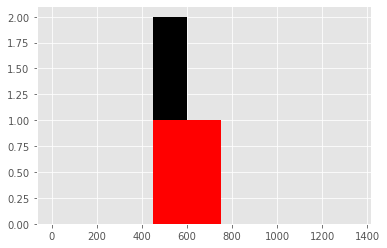

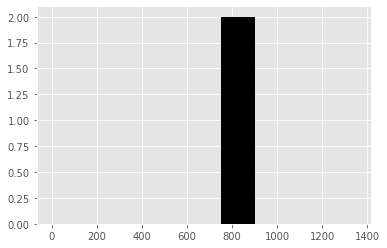

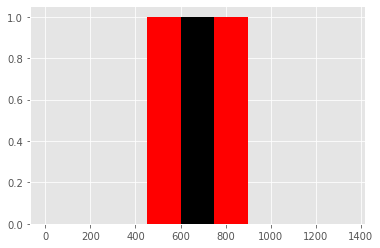

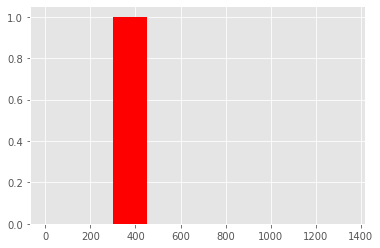

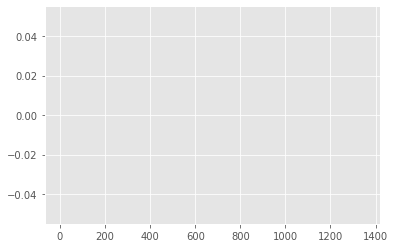

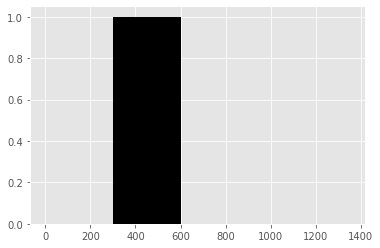

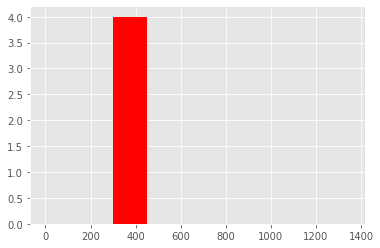

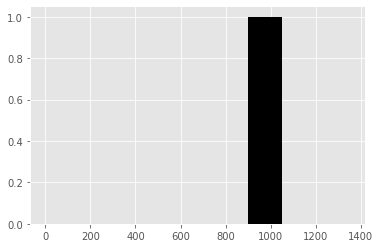

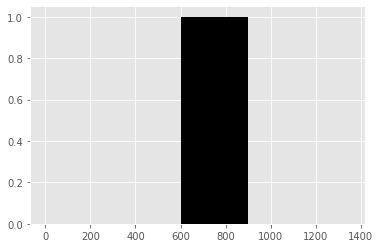

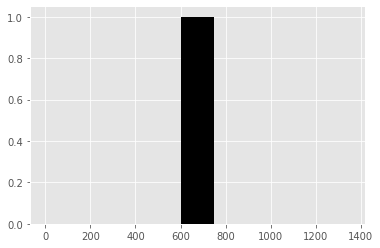

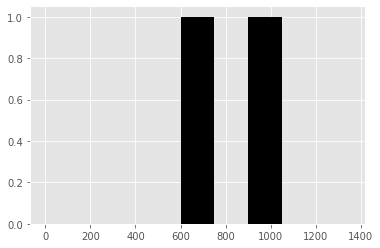

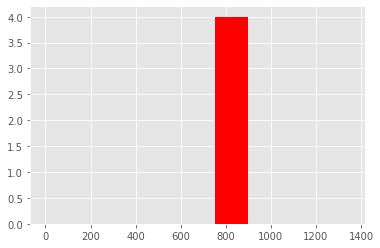

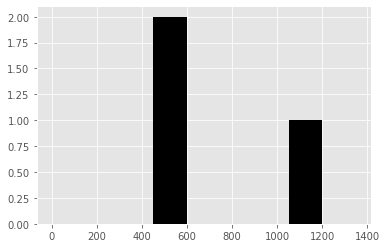

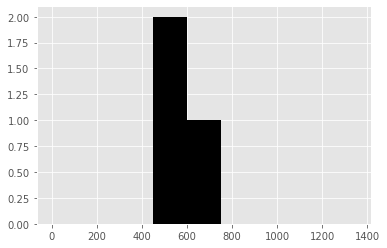

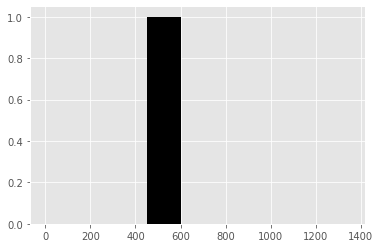

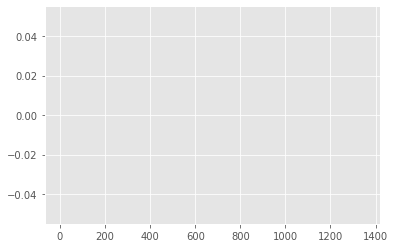

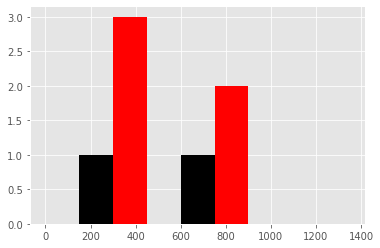

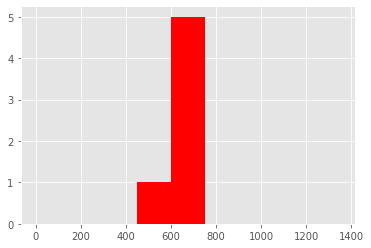

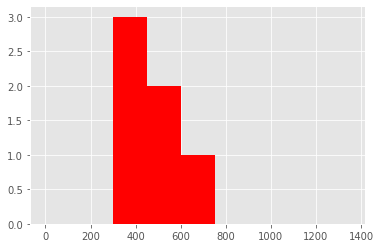

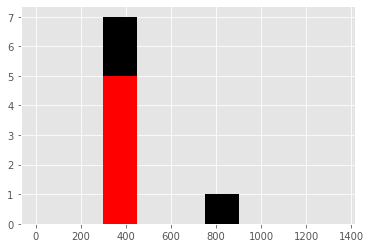

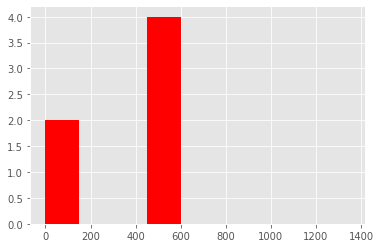

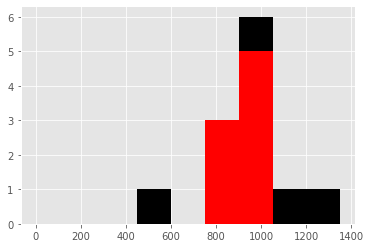

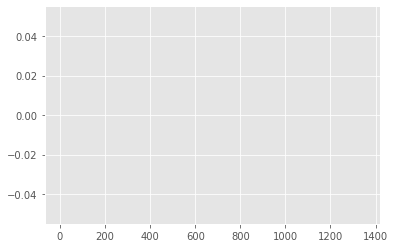

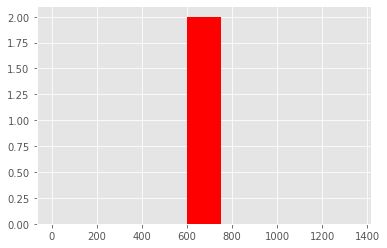

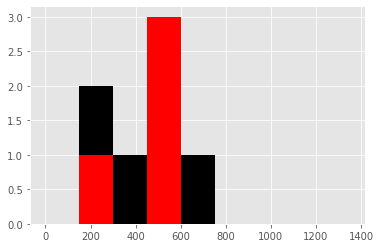

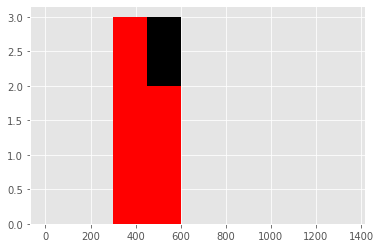

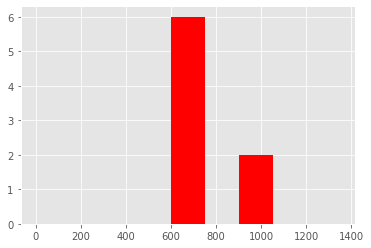

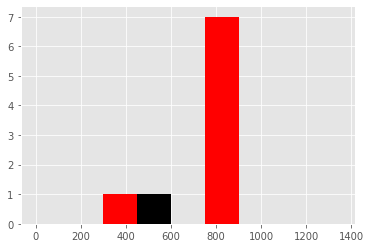

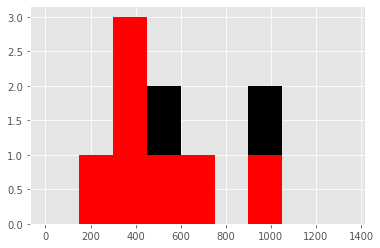

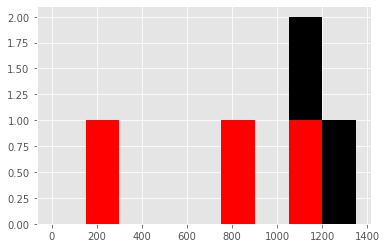

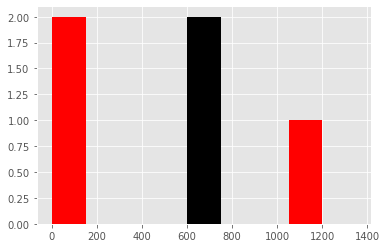

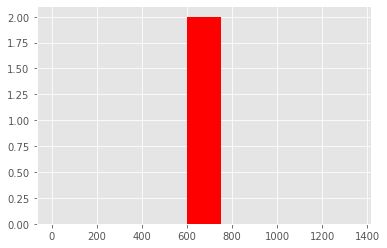

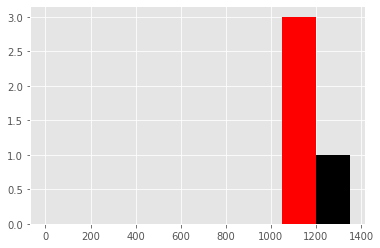

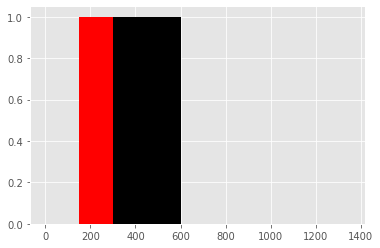

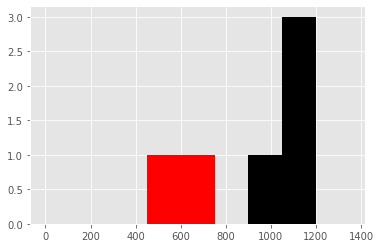

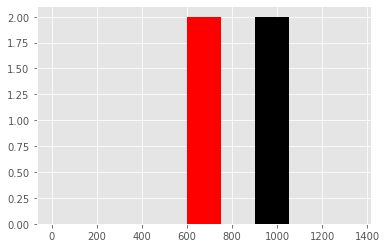

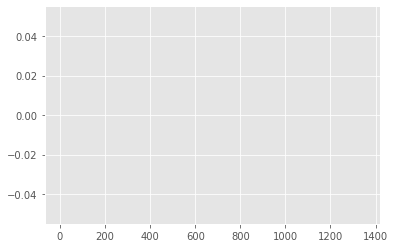

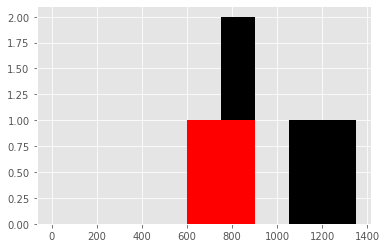

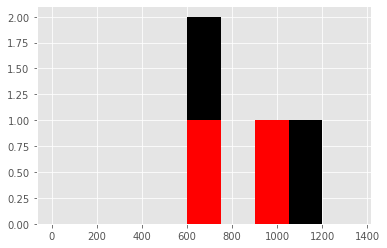

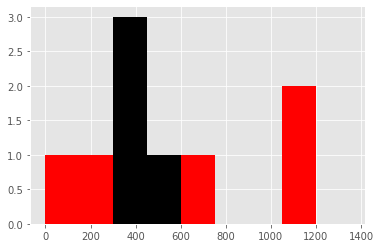

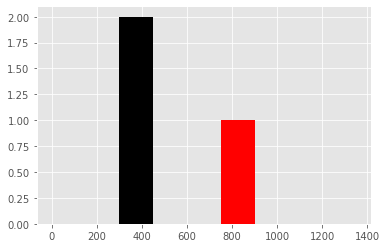

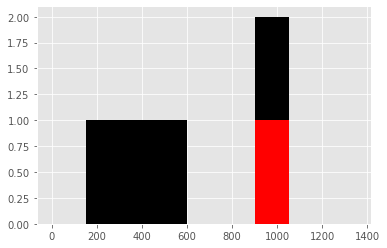

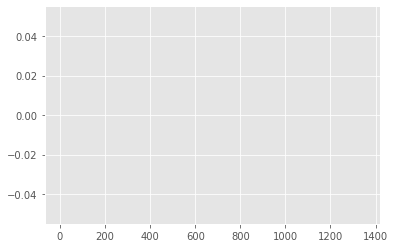

In [323]:
uniqueints = np.unique(idinfo)

for i, inte in enumerate(uniqueints):
    
    info = distanceheadall[idinfo == inte]
    
    firstpresentation = np.array(info[info[:,-2] == 'panresponsive'][:,-1], float)
    secondpresentation = np.array(info[info[:,-2] != 'panresponsive'][:,-1], float)
    
    plt.close()
    
    fig, ax = plt.subplots(1)
    ax.hist(firstpresentation, bins = bins, color = 'black')
    ax.hist(secondpresentation, bins = bins, color = 'red')
    plt.show()

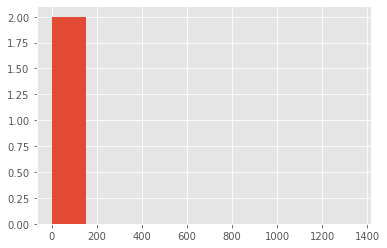

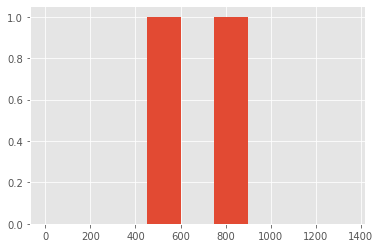

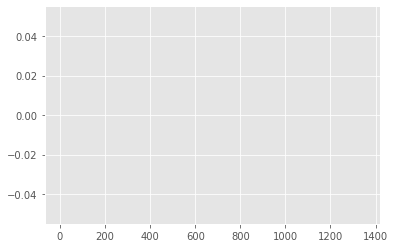

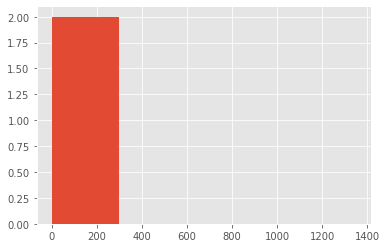

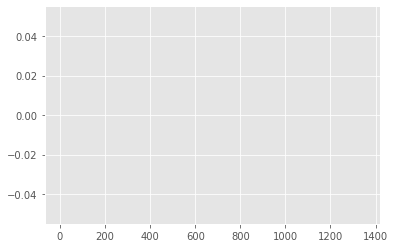

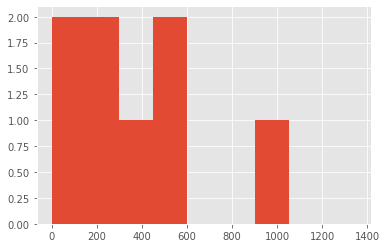

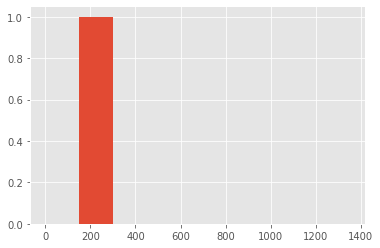

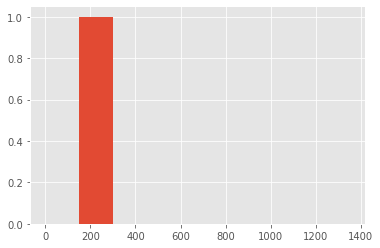

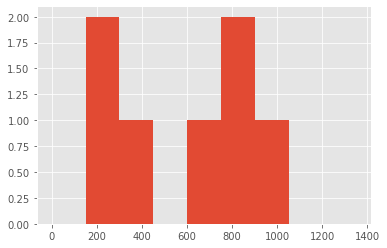

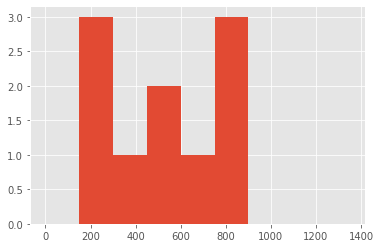

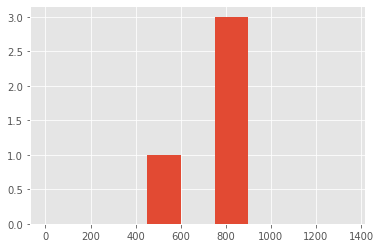

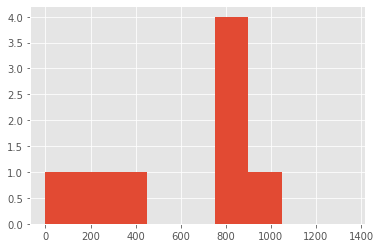

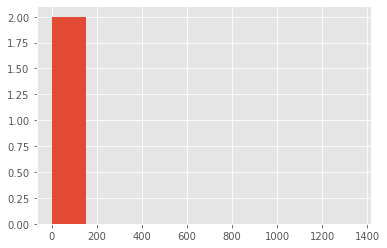

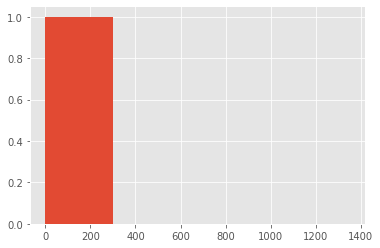

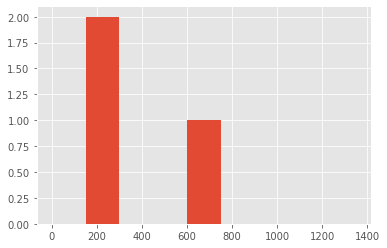

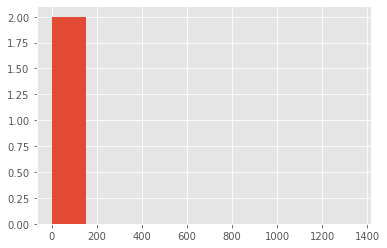

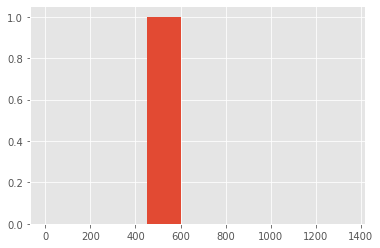

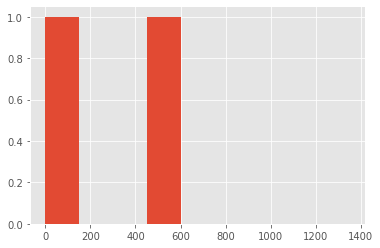

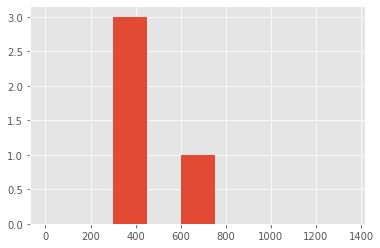

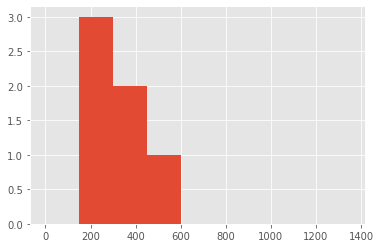

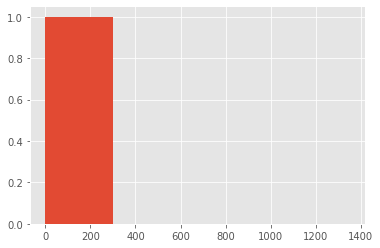

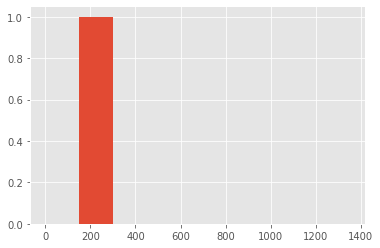

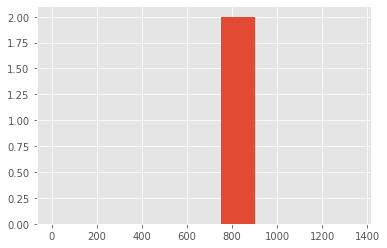

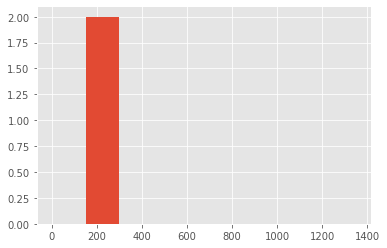

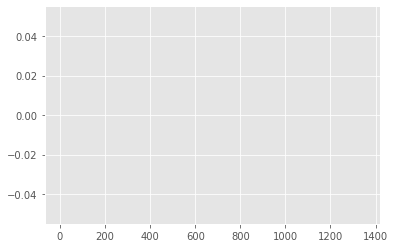

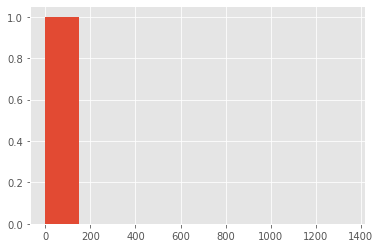

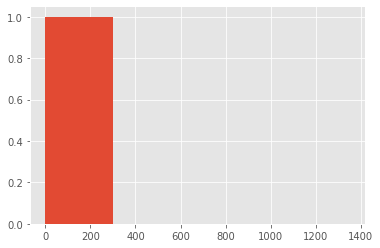

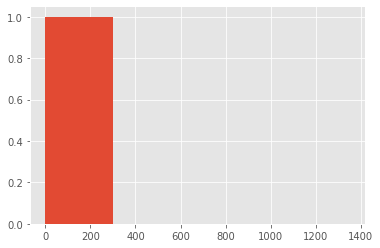

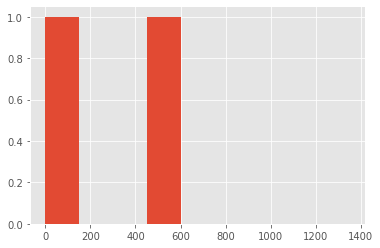

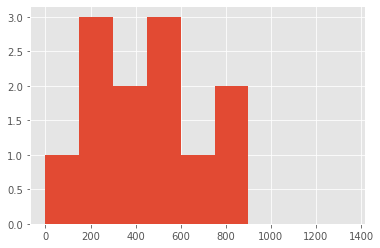

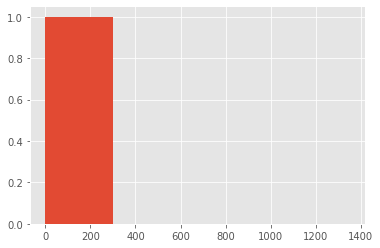

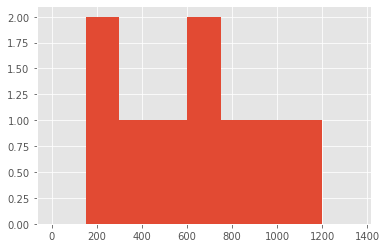

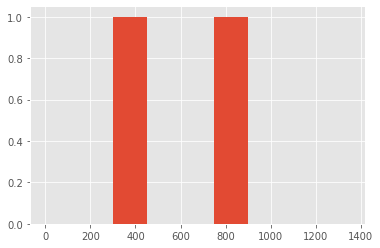

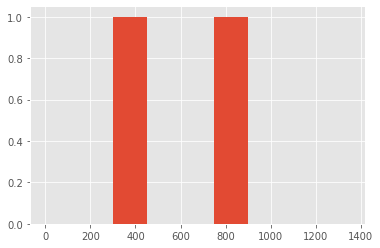

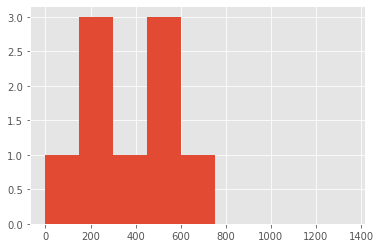

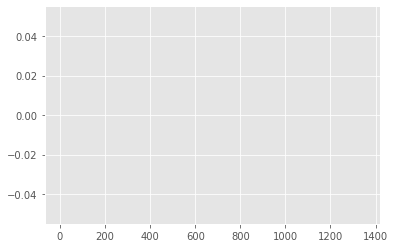

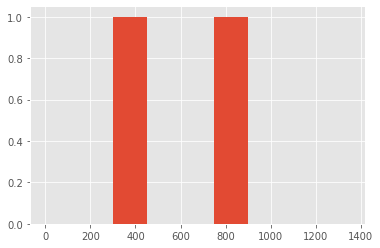

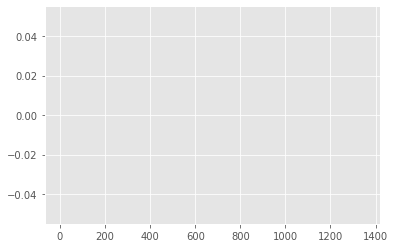

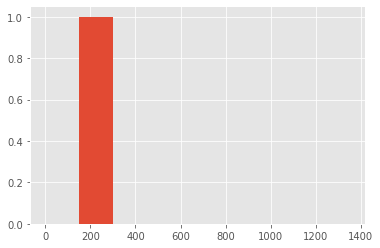

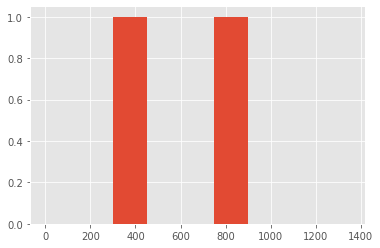

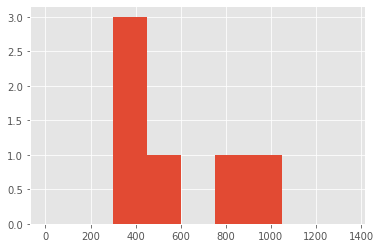

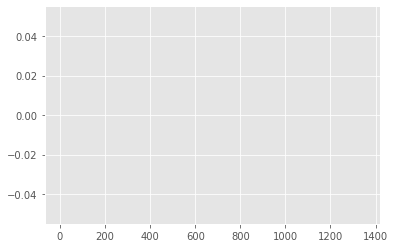

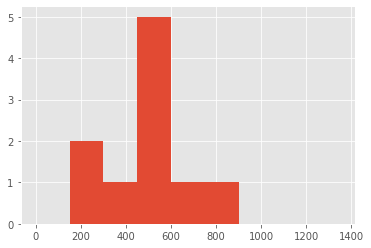

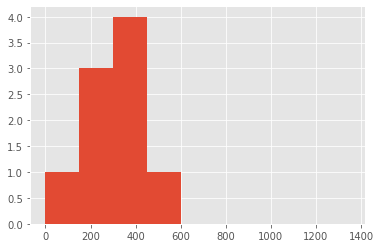

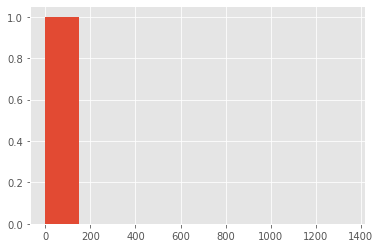

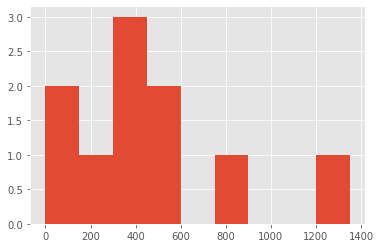

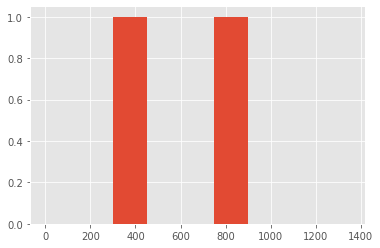

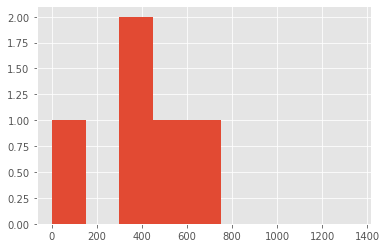

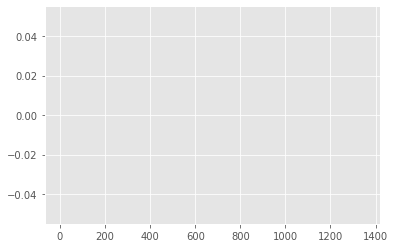

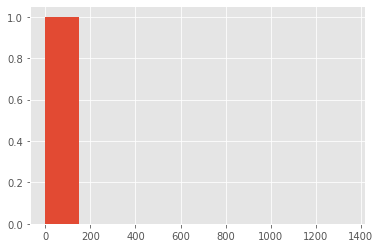

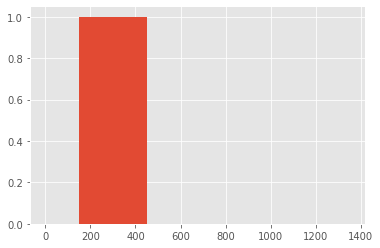

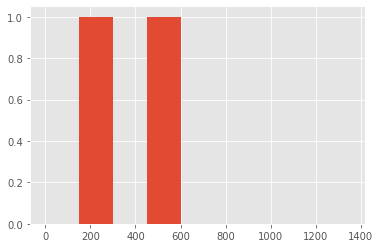

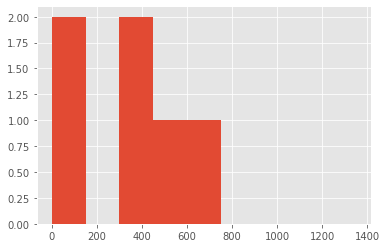

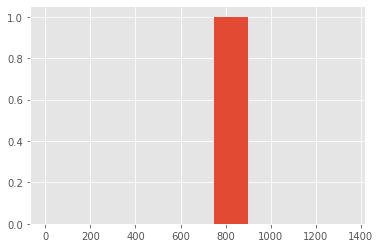

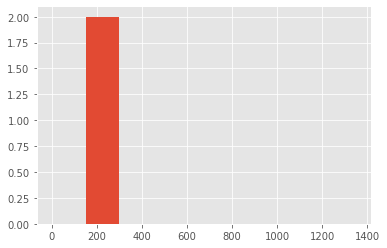

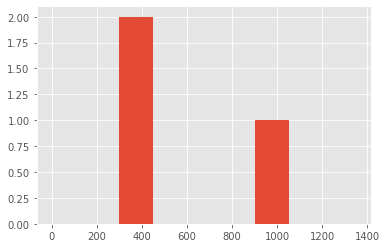

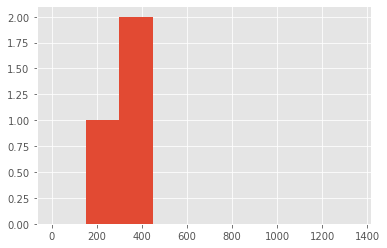

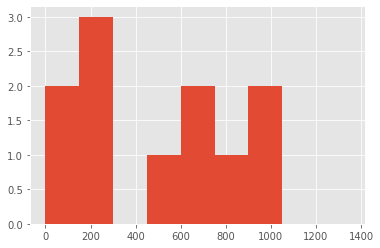

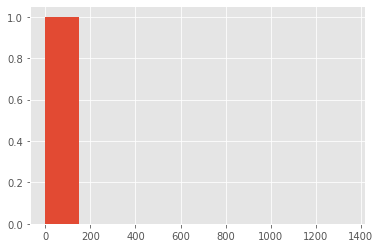

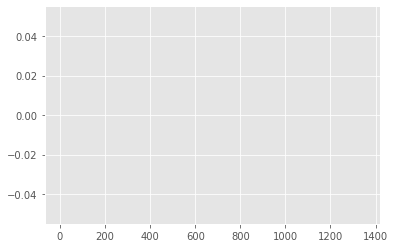

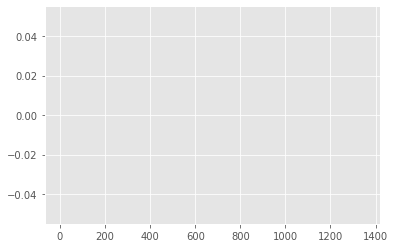

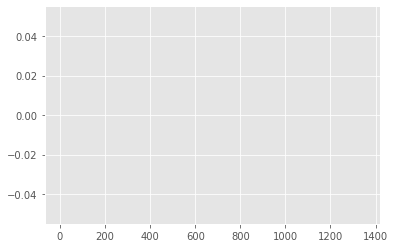

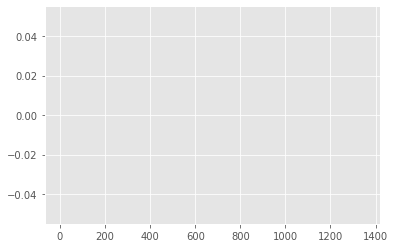

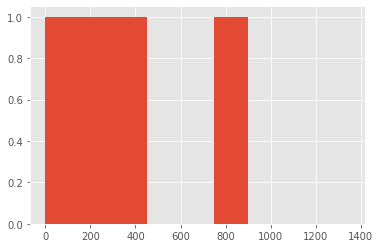

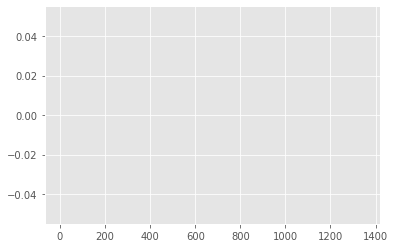

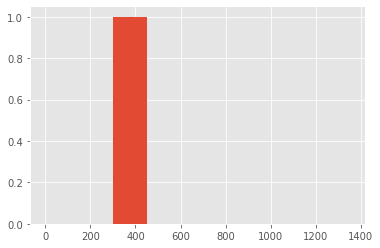

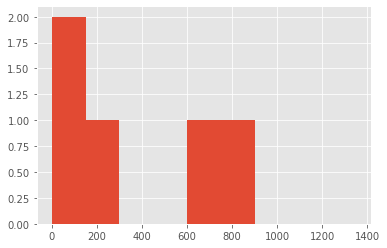

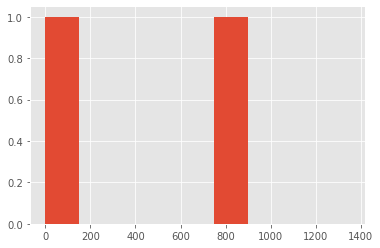

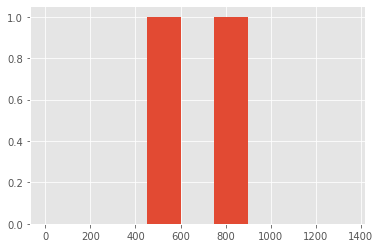

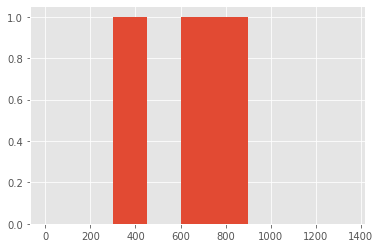

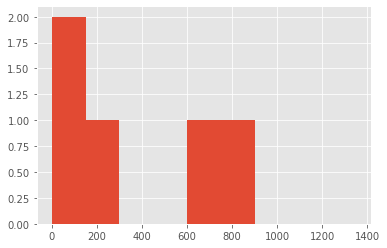

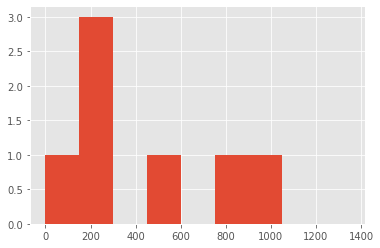

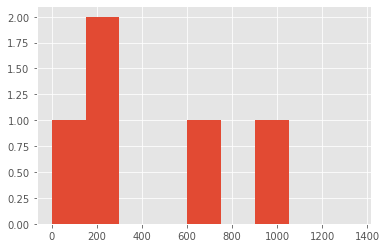

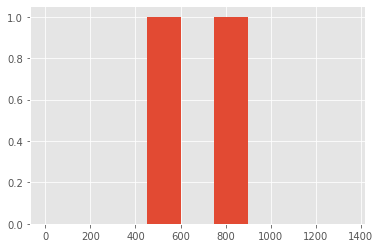

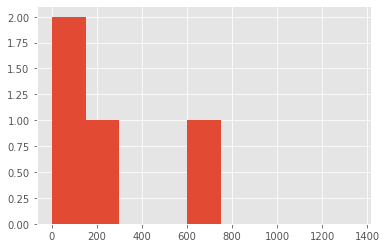

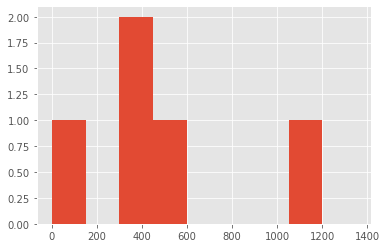

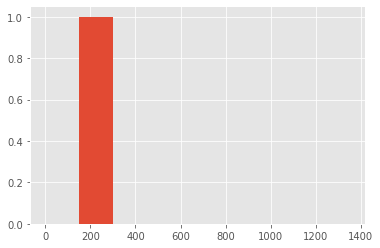

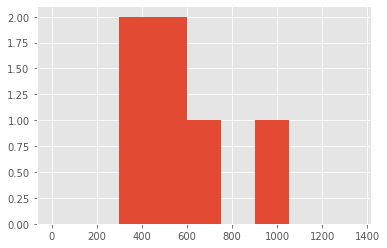

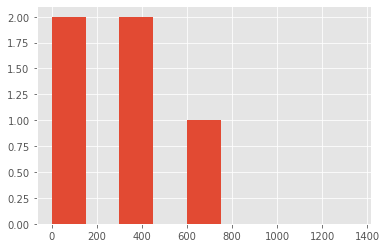

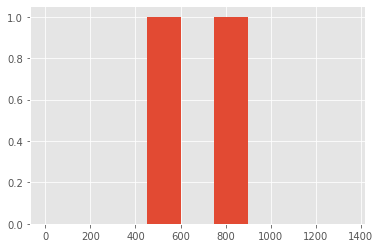

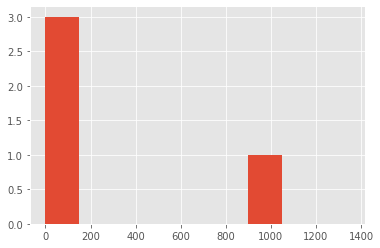

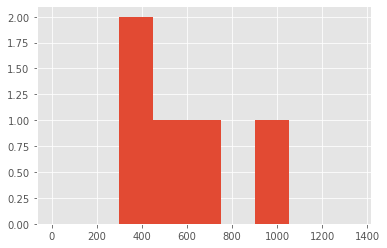

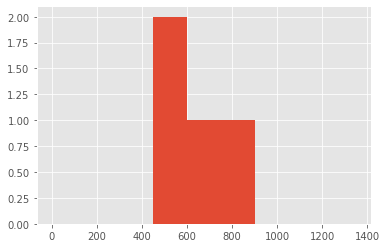

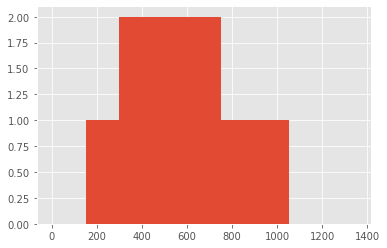

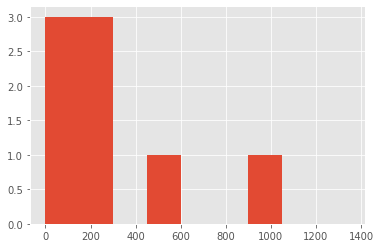

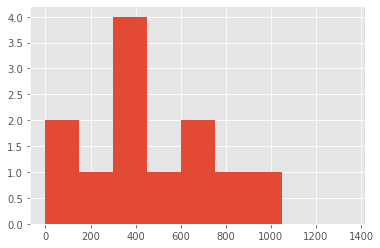

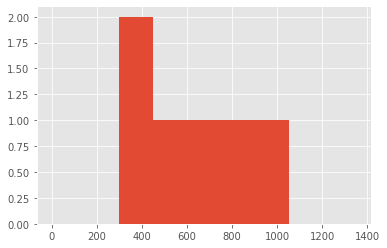

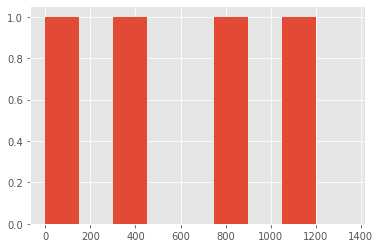

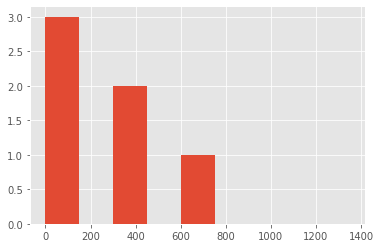

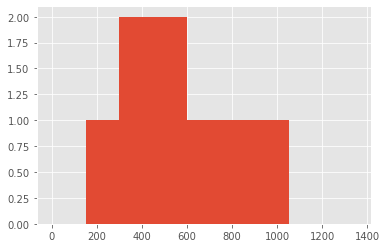

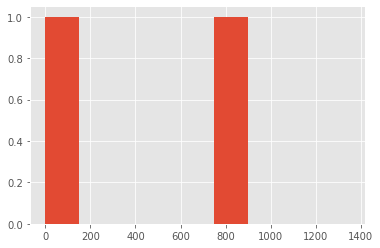

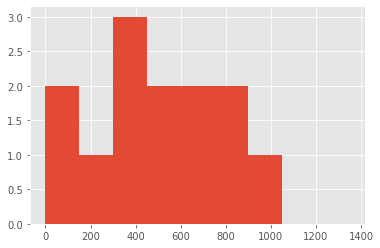

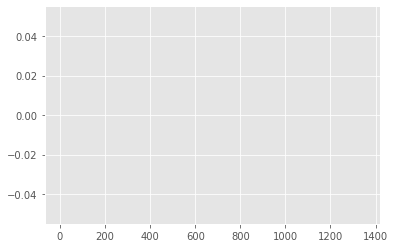

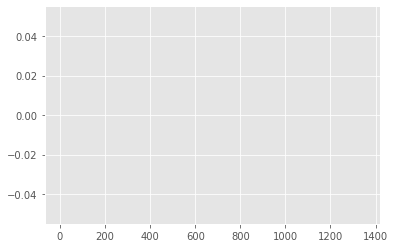

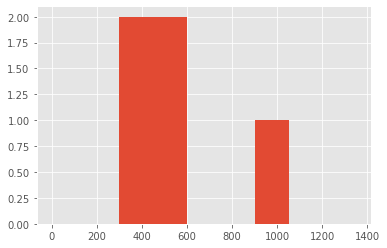

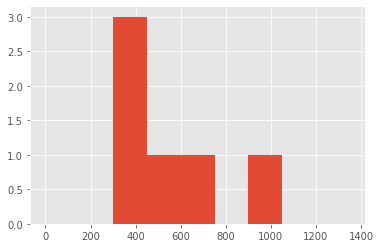

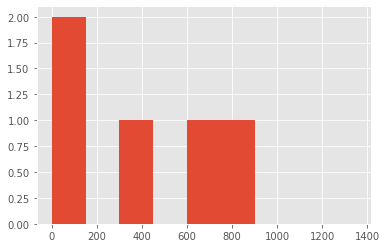

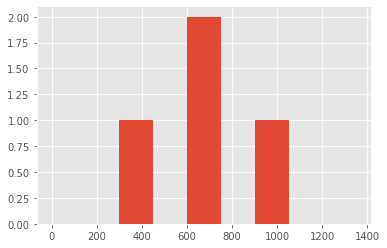

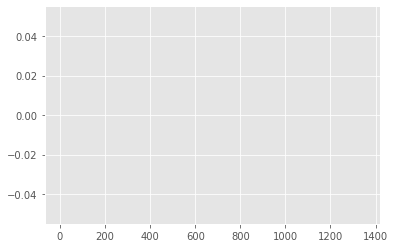

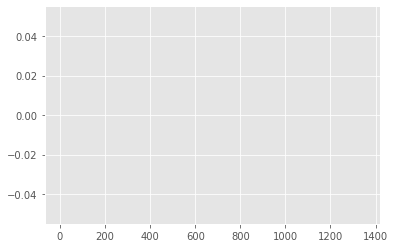

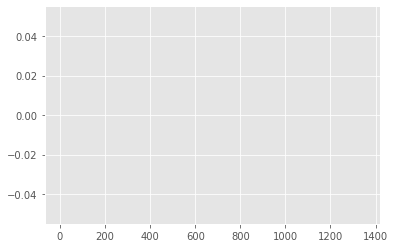

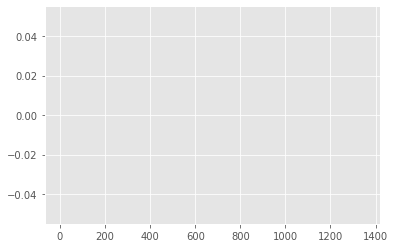

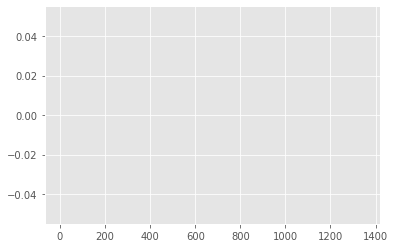

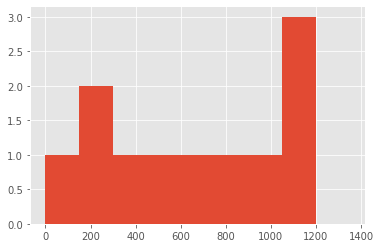

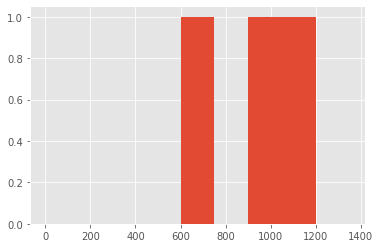

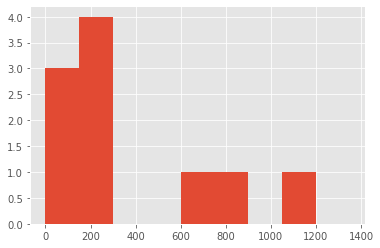

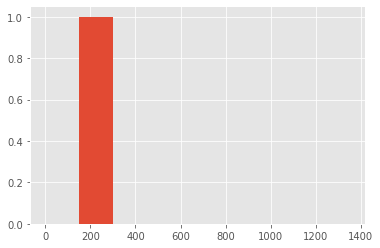

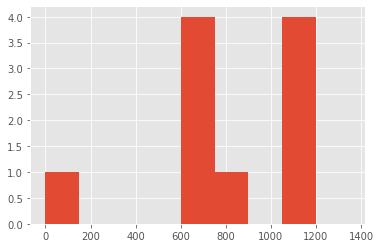

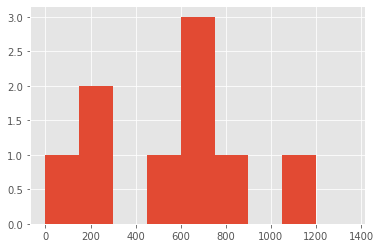

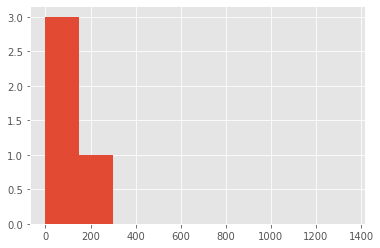

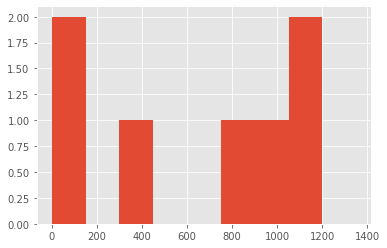

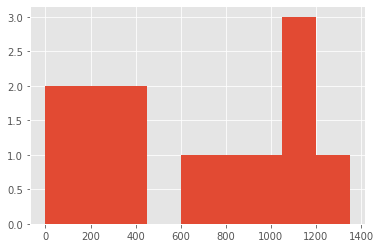

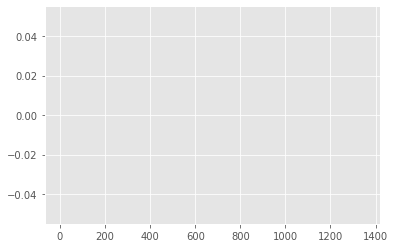

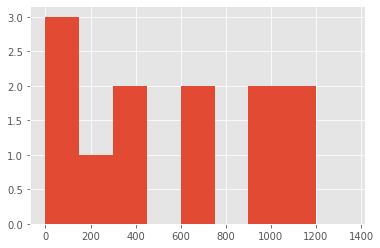

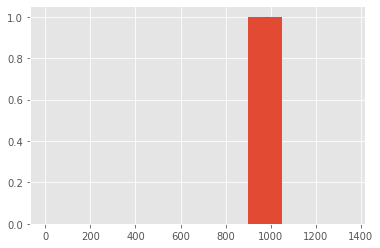

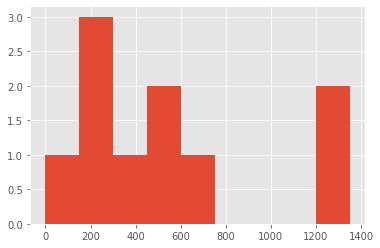

In [249]:


for i, inte in enumerate(uniqueints):
    
    individualdistance = np.array(distanceheadall[idinfo == inte][:,-1], float)
    #print(individualdistance)
    plt.close()
    fig, ax = plt.subplots(1)
    ax.hist(individualdistance, bins = bins)
    plt.show()
    
    
#plt.show()
    
    
    
    

In [243]:
bins

array([15045.409, 15046.409, 15047.409, 15048.409, 15049.409, 15050.409,
       15051.409, 15052.409, 15053.409, 15054.409, 15055.409, 15056.409,
       15057.409, 15058.409, 15059.409, 15060.409, 15061.409])

In [145]:
np.argmin(np.abs(np.array(behavioralvalues[0, 1:], np.float) - test))

556755

In [148]:
np.where(zscore_fr > 5)

(array([25], dtype=int64),)

In [149]:
len(zscore_fr)

26

In [140]:
test = np.ravel(bins[np.where(zscore_fr > 5)])

In [ ]:
savepath = 'F:/FiringStartAnalysis/'
func_format.foldercheck(savepath)

intvalues = np.loadtxt('F:/InteractionPresentation.csv', delimiter = ',', dtype = str)

date = ['13042019', '01102019', '27062020', '06072020']
intvalues = intvalues[np.isin(intvalues[:,1], date)]

neuronprofile = np.loadtxt('F:/ResponseType/ResponseType_BLA/responseprofile.csv', delimiter = ',', dtype = str)
neuronprofile = neuronprofile[np.isin(neuronprofile[:,1], date)]

for i, row in enumerate(intvalues):
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    [foldername, inttype, intcat, presentationnumber, videosync_start, videosync_stop, framerate, usableframes, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    
    syncpath = 'F:/'+row[0]+'/Electrohys/'+row[1]+'/Sync/'+row[2]+'_frameSync.csv'
    sync = np.loadtxt(syncpath, delimiter = ',', dtype = str)
    
    presentationstart = np.float32(sync[np.int(row[3])])
    contactstart = np.float32(sync[np.int(row[7])])
    presentationstop = np.float32(sync[np.int(row[5])])
    
    
    

for i, row in enumerate(neuronprofile):
    
    neuronpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/'+neuronselection+row[2]+'.npy'
    neuron = np.float_(np.ravel(np.load(neuronpath))/1000)
    
    configpath = 'F:/'+row[0]+'/Parameters_'+row[1]+'.yml'
    [foldername, inttype, intcat, presentationnumber, videosync_start, videosync_stop, framerate, usableframes, intsync_start, intsync_stop] = func_format.openconfig(configpath)
    intdetails = intvalues[np.isin(intvalues[:,1], row[1])]
    
    if row[3] != 'NoResponses':# or row[3] == 'Inhibition' or row[3] == 'NoResponses':
        continue
        
    #print(row[4])
        
    [usableint, usablepresentationnumber] = extractusableint(row[4], intcat, foldername, presentationnumber)
    #behavior = np.loadtxt('F:/'+row[0]+'/TrackingData/'+row[1]+'_rat1values.csv', delimiter = ',', dtype = str)
    
    for j, row2 in enumerate(intdetails):
        
        if np.isin(row2[2], usableint) == True:
            
            syncpath = 'F:/'+row[0]+'/Electrophys/'+row[1]+'/Sync/'+row2[2]+'_frameSync.csv'
            sync = np.loadtxt(syncpath, delimiter = ',', dtype = str)
            #camsync = np.array(behavior[0, 1:], np.float)
            #velocity = np.array(behavior[2,1:], np.float)
            
            presentationstart = np.float32(sync[np.int(row2[3])])
            contactstart = np.float32(sync[np.int(row2[7])])
            presentationstop = np.float32(sync[np.int(row2[5])])
            #if row2[6] != 'nan':
                #continue
            
            ### insert behavioral exclusion conditions here (i.e. at least 5s in between presentation and contact)
            if (contactstart - presentationstop) < 1:
                continue
            #trialvelocity = velocity[np.argmin(np.abs(camsync - presentationstart+10)):np.argmin(np.abs(camsync - contactstart-10))]
            
            [zscore_fr, bins, meanbaseline] = calculate_zscore(neuron, presentationstart-10, contactstart+10, 
                                         presentationstart-300, presentationstart, 0.1)
            zscoreresults.append([zscore_fr])
            #velocityresults.append([trialvelocity])
            
            #### timewarps data
            placementstop = np.argmin(np.abs(bins - presentationstop))
            contactbin = np.argmin(np.abs(bins - contactstart))
            
            beforepresentationfr = zscore_fr[:100]
            placementfr = zscore_fr[100:placementstop]
            beforecontactfr = zscore_fr[placementstop:contactbin]
            aftercontactfr = zscore_fr[contactbin:contactbin+99]
            
            rawvalues = (meanbaseline, np.mean(beforepresentationfr), np.mean(placementfr), np.mean(beforecontactfr), np.mean(aftercontactfr))
            rawvaluesave = np.vstack((rawvaluesave, rawvalues))
            
            placementfr = timewarp_interpolate(placementfr, 50)
            beforecontactfr = timewarp_interpolate(beforecontactfr, 200)
            
            timewarp_fr = np.hstack((beforepresentationfr, placementfr, beforecontactfr, aftercontactfr))
            timewarpresults = np.vstack((timewarpresults, timewarp_fr))